# Chargement du fichier

In [1]:
import pandas as pd

# Chargement du fichier
df1 = pd.read_csv("data/df1.csv")

---------------------------------------

# Préparation de la donnée pour la modélisation

X = toutes les colonnes explicatives (brutes)  
y = la colonne cible

In [2]:
X = df1.drop(columns="a_quitte_l_entreprise")
y = df1["a_quitte_l_entreprise"]

In [3]:
# On importe la fonction train_test_split depuis la bibliothèque scikit-learn. Cette fonction sert à séparer les données en un jeu d'entraînement et un jeu de test
from sklearn.model_selection import train_test_split

# On découpe les données X (entrées) et y (résultats) en 4 parties :
# - X_train : données utilisées pour entraîner le modèle
# - X_test  : données utilisées pour tester le modèle
# - y_train : résultats associés aux données d'entraînement
# - y_test  : résultats associés aux données de test
X_train, X_test, y_train, y_test = train_test_split(
    # X contient les variables explicatives (les données d'entrée)
    X,
    # y contient la variable cible (ce que le modèle doit prédire)
    y,
    # 20% des données seront utilisées pour le test
    test_size=0.2,
    # On fixe une valeur pour obtenir toujours la même séparation. Cela permet de reproduire exactement les mêmes résultats
    random_state=42,
    # On garde la même proportion de classes dans le train et le test
    stratify=y
)

### Encodage des variables qualitatives

On n’encode pas toutes les variables qualitatives de la même façon. Le choix dépend de :
- Nombre de modalités
- Taille de chaque modalité
- Sens métier (ordre, hiérarchie)
- Type de modèle (linéaire vs arbre)

**frequence_deplacement** : Aucun < Occasionnel < Frequent  

Encodage ordinal car la variable a un ordre logique clair et cela permet de respecter le sens métier

**statut_marital**, **poste**, **departement** et **domaine_etude** vont être encodé par la méthode One-Hot Encoding car elles n'ont pas d'ordre naturel. 

### Pipeline de preprocessing unique

Un pipeline est une façon organisée et automatique d’enchaîner plusieurs étapes de traitement des données dans un ordre précis.

Dans le contexte de l’apprentissage automatique, un pipeline regroupe toutes les étapes nécessaires pour passer des données brutes à une prédiction finale. Par exemple :
- nettoyer les données
- transformer ou normaliser les variables
- entraîner un modèle
- faire une prédiction

L’idée est que les données passent étape par étape, comme sur une chaîne de montage. Chaque étape reçoit le résultat de la précédente et effectue sa propre tâche.

L’avantage principal d’un pipeline est qu’il rend le travail plus clair, plus sûr et plus reproductible. On évite les oublis, les erreurs de manipulation et les incohérences entre l’entraînement du modèle et son utilisation réelle.

En résumé, un pipeline est une structure qui permet de regrouper et d’automatiser toutes les étapes d’un processus de modélisation, afin d’obtenir des résultats cohérents et faciles à reproduire.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

Définition des features

In [5]:
# Variables numériques
features_numeriques = [
    "age",
    "revenu_mensuel",
    "annees_dans_l_entreprise",
    "annees_depuis_la_derniere_promotion",
    "heure_supplementaires",
    "note_evaluation",
    "genre",
    "nombre_experiences_precedentes",
    "augmentation_salaire_precedente",
    "satisfaction_globale",
    "nombre_participation_pee",
    "nb_formations_suivies",
    "distance_domicile_travail",
    "niveau_education",
    "niveau_hierarchique_poste"
]

# Variable ordinale
features_ordinales = [
    "frequence_deplacement"
]

# Variables catégorielles
features_onehot = [
    "statut_marital",
    "domaine_etude",
    "departement",
    "poste"
]

Un pipeline de prétraitement unique a été défini et réutilisé pour l’entraînement de plusieurs modèles afin de garantir la cohérence des transformations et l’absence de fuite d’information.

In [6]:
# On crée un objet appelé "preprocessor". Il servira à préparer les données avant de les donner au modèle
preprocessor = ColumnTransformer(
    # "transformers" contient la liste des traitements à appliquer
    transformers=[
        # Traitement des variables numériques
        ("num", Pipeline([
            # Remplace les valeurs manquantes par la médiane de la colonne, la médiane est souvent plus robuste que la moyenne
            ("imputer", SimpleImputer(strategy="median")),
            # Met toutes les valeurs numériques sur la même échelle (moyenne = 0 et écart-type = 1)
            ("scaler", StandardScaler())
        # Liste des colonnes numériques concernées    
        ]), features_numeriques),

        # Traitement des variables ordinales
        ("ord", Pipeline([
            # Remplace les valeurs manquantes par la valeur la plus fréquente
            ("imputer", SimpleImputer(strategy="most_frequent")),
            # Transforme des catégories ordonnées en nombres exemple : Aucun = 0, Occasionnel = 1, Frequent = 2
            ("ordinal", OrdinalEncoder(
                categories=[["Aucun", "Occasionnel", "Frequent"]]
            ))
        # Liste des colonnes ordinales    
        ]), features_ordinales),

        # Traitement des variables catégorielles (One-Hot Encoding)
        ("ohe", Pipeline([
            # Remplace les valeurs manquantes par la valeur la plus fréquente
            ("imputer", SimpleImputer(strategy="most_frequent")),
            # Transforme chaque catégorie en colonnes binaires (0 ou 1)
            ("onehot", OneHotEncoder(
                # Supprime la première catégorie pour éviter la redondance
                drop="first",
                # Ignore les catégories inconnues rencontrées lors du test
                handle_unknown="ignore"
            ))
        # Liste des colonnes catégorielles    
        ]), features_onehot),
    ]
)

--------------------------------------------------

# Entraînement des modèles

Plusieurs modèles supervisés ont été entraînés à partir d’un pipeline de prétraitement commun afin de garantir une comparaison équitable.

Un modèle supervisé est un modèle d’apprentissage automatique qui apprend à partir d’exemples déjà connus. Concrètement, on lui donne des données accompagnées de la bonne réponse. Par exemple :
- des emails avec l’indication “spam” ou “non spam” ;
- des données médicales avec “malade” ou “pas malade” ;
- des informations sur des maisons avec leur prix réel.

Le modèle observe ces exemples et cherche à comprendre le lien entre les informations d’entrée et la réponse attendue. Une fois entraîné, il peut utiliser ce qu’il a appris pour prédire la réponse pour de nouvelles données qu’il n’a jamais vues.

On parle de “supervisé” parce que le modèle est guidé par les réponses correctes pendant l’apprentissage. 

En résumé, un modèle supervisé apprend à partir de données étiquetées (avec la bonne réponse) afin de pouvoir faire des prédictions fiables sur de nouveaux cas.

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

### Dummy

Un Dummy Classifier est un modèle volontairement très simple qui ne cherche pas vraiment à apprendre.

Il peut par exemple :
- toujours prédire la classe majoritaire
- prédire au hasard
- prédire selon la fréquence des classes

Un Dummy permet de :
- servir de référence minimale
- vérifier que les vrais modèles font mieux que le hasard

In [8]:
# On crée un pipeline appelé "pipe_dummy"
pipe_dummy = Pipeline([
    # Première étape : le prétraitement des données. On utilise le "preprocessor" défini auparavant. Il nettoie et transforme les données (valeurs manquantes, encodage, normalisation)
    ("preprocess", preprocessor),
    # Deuxième étape : le modèle de machine learning. DummyClassifier est un modèle très simple. Il sert de modèle de référence (baseline)
    ("model", DummyClassifier(strategy="most_frequent"))
])

### Régression Logistique

La régression logistique est une méthode statistique utilisée pour prédire une réponse qui a seulement deux possibilités. Par exemple :
- oui / non
- malade / pas malade
- acheter / ne pas acheter

Contrairement à ce que son nom pourrait laisser croire, elle ne sert pas à prédire un nombre, mais une probabilité.

L’idée est la suivante : on dispose de plusieurs informations sur une situation (par exemple l’âge d’une personne, son revenu, le nombre d’heures de sport qu’elle fait). À partir de ces informations, la régression logistique cherche à estimer la probabilité qu’un événement se produise. Par exemple : la probabilité qu’une personne soit malade ou qu’un client achète un produit.

Le résultat du modèle est toujours un nombre entre 0 et 1. Ce nombre représente une probabilité. Par exemple, un résultat de 0,8 signifie qu’il y a 80 % de chances que l’événement se produise. Ensuite, on peut décider d’un seuil (souvent 0,5) pour transformer cette probabilité en une décision finale :
- si la probabilité est supérieure à 0,5 → “oui”
- si elle est inférieure à 0,5 → “non”

La régression logistique utilise une fonction mathématique appelée fonction logistique. Cette fonction a une forme de courbe en S. Elle permet de transformer n’importe quel nombre en une valeur comprise entre 0 et 1, ce qui est parfait pour représenter une probabilité.

En résumé, la régression logistique est un outil qui permet, à partir de plusieurs informations, d’estimer la probabilité qu’un événement binaire se produise, puis éventuellement de prendre une décision à partir de cette probabilité.

In [9]:
# On crée un pipeline appelé "pipe_logreg"
pipe_logreg = Pipeline([
    # Première étape : le prétraitement des données. On utilise le même "preprocessor" que précédemment. Cela garantit que les données sont traitées de la même façon
    ("preprocess", preprocessor),
    # Deuxième étape : le modèle de machine learning. LogisticRegression est un vrai modèle de classification. Il apprend à partir des données pour faire des prédictions
    ("model", LogisticRegression(max_iter=1000))
])

### Random Forest

Un random forest (ou forêt aléatoire) est une méthode de prédiction qui fonctionne en combinant les décisions de nombreux arbres plutôt qu’en s’appuyant sur un seul modèle.

Pour comprendre l’idée, un arbre de décision pose une suite de questions simples, par exemple :
- “Est-ce que la personne a plus de 30 ans ?”
- “Est-ce que son revenu est élevé ?”
À la fin de ces questions, l’arbre donne une réponse, comme “oui” ou “non”, ou parfois une valeur numérique.

Le problème d’un seul arbre est qu’il peut être trop influencé par les données sur lesquelles il a été entraîné. Il peut bien fonctionner sur ces données, mais se tromper sur de nouveaux cas.

Le random forest résout ce problème en créant beaucoup d’arbres de décision différents. Chaque arbre est entraîné sur un échantillon légèrement différent des données, et chaque arbre ne regarde qu’une partie des informations disponibles à chaque question. Cela introduit de l’aléatoire, ce qui rend les arbres moins semblables les uns aux autres.

Une fois tous les arbres construits, chacun donne sa propre prédiction.

Pour un problème de classification (oui / non, par exemple), le random forest choisit la réponse la plus votée par les arbres.

Pour un problème de prédiction numérique, il fait la moyenne des résultats des arbres.

L’idée principale est que plusieurs avis indépendants donnent en général une meilleure décision qu’un seul avis. Même si certains arbres se trompent, la majorité peut quand même donner une bonne réponse.

En résumé, le random forest est une méthode puissante et robuste qui combine de nombreux arbres de décision pour faire des prédictions plus fiables.

In [10]:
# On crée un pipeline appelé "pipe_rf"
pipe_rf = Pipeline([
    # Première étape : le prétraitement des données. On réutilise le même "preprocessor". Cela garantit que toutes les données sont traitées de la même manière
    ("preprocess", preprocessor),
    # Deuxième étape : le modèle de machine learning. RandomForestClassifier est un modèle puissant basé sur des arbres de décision
    ("model", RandomForestClassifier(
        # Nombre d'arbres créés dans la forêt : plus il y a d'arbres, plus le modèle est généralement stable
        n_estimators=300,
        # Permet d'obtenir toujours les mêmes résultats. Utile pour la reproductibilité des expériences
        random_state=42
    ))
])

### XGBoost

Le XGBoost (pour Extreme Gradient Boosting) est une méthode de prédiction basée sur des arbres de décision, comme le random forest, mais avec une logique différente et plus progressive.

L’idée principale du XGBoost est de construire les arbres les uns après les autres, et non tous indépendamment. Chaque nouvel arbre est créé pour corriger les erreurs faites par les arbres précédents.

Au départ, le modèle fait une première prédiction simple. Cette prédiction est imparfaite, donc il y a des erreurs. XGBoost analyse alors ces erreurs et construit un nouvel arbre dont le rôle est de mieux prédire les cas où le modèle s’est trompé. Ce processus se répète : à chaque étape, un nouvel arbre vient améliorer progressivement le modèle existant.

Contrairement au random forest, où tous les arbres ont le même poids, dans XGBoost chaque arbre contribue de façon contrôlée au résultat final. On ajoute les arbres petit à petit, avec une influence limitée, ce qui permet d’éviter que le modèle ne devienne trop complexe ou trop sensible aux données.

XGBoost utilise aussi plusieurs astuces pour être rapide et efficace :
- il pénalise les modèles trop complexes pour éviter le surapprentissage
- il gère bien les données manquantes
- il est optimisé pour calculer vite, même sur de grandes bases de données

Le résultat final est une prédiction obtenue en additionnant les contributions de tous les arbres. Comme chaque arbre s’est concentré sur les erreurs précédentes, le modèle final est souvent très précis.

En résumé, XGBoost est une méthode très performante qui combine de nombreux arbres de décision construits progressivement, chacun servant à corriger les erreurs du précédent.

In [11]:
# On crée un pipeline appelé "pipe_xgb"
pipe_xgb = Pipeline([
    # Première étape : le prétraitement des données. On utilise le même "preprocessor" que pour les autres modèles. Cela garantit une comparaison équitable entre les modèles
    ("preprocess", preprocessor),
    # Deuxième étape : le modèle de machine learning. XGBClassifier est un modèle puissant basé sur le boosting
    ("model", XGBClassifier(
        # Fonction utilisée pour évaluer les erreurs pendant l'entraînement. "logloss" est adaptée aux problèmes de classification
        eval_metric="logloss",
        # Fixe le hasard pour obtenir des résultats reproductibles
        random_state=42
    ))
])

### SVC (linéaire)

Le SVC linéaire (Support Vector Classifier linéaire) est une méthode de classification, c’est-à-dire qu’elle sert à séparer des données en catégories, par exemple oui / non.

L’idée du SVC linéaire est de trouver une frontière de séparation entre deux groupes de données. Cette frontière est une droite (en deux dimensions) ou, plus généralement, un plan dans un espace avec plus de dimensions. Le but est de placer cette frontière de façon à bien séparer les deux groupes.

Ce qui rend le SVC spécial, c’est qu’il ne cherche pas n’importe quelle frontière, mais celle qui laisse le plus grand espace possible entre les deux groupes. Cet espace s’appelle la marge. Plus la marge est grande, plus le modèle est robuste, c’est-à-dire qu’il résiste mieux au bruit et aux petites variations dans les données.

Seules quelques données, celles qui sont les plus proches de la frontière, sont vraiment importantes pour construire le modèle. On les appelle les vecteurs de support. Ce sont elles qui déterminent exactement où se place la frontière.

Le terme linéaire signifie que le modèle suppose que les données peuvent être séparées par une frontière droite. Il est donc surtout adapté aux situations où la relation entre les informations et la catégorie à prédire est relativement simple.

Un paramètre important du SVC linéaire permet de choisir entre :
- une séparation très stricte, qui cherche à bien classer toutes les données mais risque d’être trop rigide
- une séparation plus souple, qui accepte quelques erreurs pour mieux généraliser à de nouvelles données

En résumé, le SVC linéaire est une méthode efficace pour classer des données lorsque les groupes sont assez bien séparés. Il se concentre sur les exemples les plus importants et cherche une séparation stable. 

In [12]:
# On crée un pipeline appelé "pipe_svc_linear"
pipe_svc_linear = Pipeline([
    # Première étape : le prétraitement des données. On utilise le même "preprocessor" que pour tous les modèles. Cela permet de comparer les performances de façon équitable
    ("preprocess", preprocessor),
    # Deuxième étape : le modèle de machine learning. SVC est un classifieur basé sur les machines à vecteurs de support (SVM)
    # Utilise une frontière de décision linéaire. Adapté quand les données sont séparables de façon simple. Permet de calculer des probabilités de prédiction
    ("model", SVC(kernel="linear", probability=True))
])

### SVC (non linéaire)

Le SVC non linéaire est une méthode de classification utilisée lorsque les données ne peuvent pas être séparées par une simple droite (ou un plan). Il s’agit d’une extension du SVC linéaire, conçue pour gérer des situations plus complexes.

L’idée de base reste la même : on cherche une frontière qui sépare le mieux possible deux groupes de données tout en laissant une marge maximale entre eux. La différence est que, cette fois, la frontière n’est pas droite. Elle peut être courbée ou avoir une forme complexe.

Pour rendre cela possible, le SVC non linéaire utilise une astuce appelée le noyau (kernel). Plutôt que de séparer directement les données dans leur espace d’origine, le modèle les transforme dans un espace plus complexe, avec plus de dimensions. Dans cet espace, il devient souvent possible de tracer une séparation droite, même si la séparation semble courbe dans l’espace initial.

Il existe différents types de noyaux, par exemple :
- le noyau polynomial, qui permet des séparations en forme de courbes
- le noyau gaussien (ou RBF), très utilisé, qui permet des frontières très flexibles
- d’autres noyaux adaptés à des cas particuliers

Comme pour le SVC linéaire, seules certaines données sont essentielles pour définir la frontière : ce sont les vecteurs de support, situés près de la limite entre les groupes. Ce sont eux qui influencent réellement la forme de la séparation.

Le SVC non linéaire est puissant, mais il demande plus de réglages et de calculs. S’il est mal configuré, il peut trop s’adapter aux données d’entraînement et moins bien généraliser à de nouvelles données.

En résumé, le SVC non linéaire est un outil très efficace pour classer des données lorsque la séparation est complexe. Grâce aux noyaux, il peut créer des frontières flexibles et précises, ce qui le rend très utile pour des problèmes où les relations entre les données ne sont pas simples.

In [13]:
# On crée un pipeline appelé "pipe_svc_rbf"
pipe_svc_rbf = Pipeline([
    # Première étape : le prétraitement des données. On réutilise le même "preprocessor". Cela garantit que les données sont traitées de la même façon
    ("preprocess", preprocessor),
    # Utilise un noyau RBF (Radial Basis Function). Il permet de créer des frontières de décision non linéaires
    ("model", SVC(kernel="rbf", probability=True))
])

### Comparaison des modèles

In [14]:
# On importe la fonction cross_val_score depuis scikit-learn. Elle permet d'évaluer un modèle avec une validation croisée
from sklearn.model_selection import cross_val_score

# On crée un dictionnaire qui associe un nom à chaque pipeline de modèle
# La clé est le nom du modèle (en texte)
# La valeur est le pipeline correspondant
models = {
    "Dummy": pipe_dummy,
    "LogisticRegression": pipe_logreg,
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb,
    "SVC_Linear": pipe_svc_linear,
    "SVC_RBF": pipe_svc_rbf
}

# On parcourt chaque modèle du dictionnaire
# name = nom du modèle
# model = pipeline du modèle
for name, model in models.items():
    # On évalue le modèle avec une validation croisée
    scores = cross_val_score(
        # Le pipeline à évaluer (prétraitement + modèle). X : les données d'entrée, y : la variable cible
        model, X, y,
        # Nombre de plis pour la validation croisée (ici les données sont découpées en 5 parties)
        cv=5,
        # Métrique utilisée pour l'évaluation : le recall mesure la capacité à détecter les vrais positifs (c'est-à-dire les employés qui quittent l'entreprise)
        scoring="recall"
    )
    # On affiche le nom du modèle et la moyenne du recall. ":.3f" signifie qu'on affiche 3 chiffres après la virgule
    print(f"{name} Recall: {scores.mean():.3f}")

Dummy Recall: 0.000
LogisticRegression Recall: 0.380
RandomForest Recall: 0.182
XGBoost Recall: 0.346
SVC_Linear Recall: 0.376
SVC_RBF Recall: 0.249


Dans le cadre de cette étude, l’objectif du modèle est d’identifier les employés susceptibles de quitter l’entreprise afin de permettre aux équipes RH d’anticiper ces départs et de mettre en place des actions de rétention adaptées. La classe positive correspond donc aux employés quittant l’entreprise. Dans ce contexte, la métrique de recall est particulièrement pertinente, car elle mesure la capacité du modèle à détecter les départs effectifs. Un **faux négatif** (c’est-à-dire un employé à risque non détecté) représente en effet une perte d’opportunité d’intervention, souvent plus coûteuse qu’un faux positif.

Les résultats montrent que le modèle Dummy obtient un recall nul, ce qui signifie qu’il ne détecte aucun départ. Ce comportement correspond à une stratégie consistant à prédire systématiquement la classe majoritaire.

Parmi les modèles évalués, la régression logistique obtient le meilleur recall, avec une valeur de 0,38. Cela signifie qu’environ 38 % des employés qui quittent effectivement l’entreprise sont correctement identifiés par le modèle. Ce résultat, bien que perfectible, constitue une base exploitable pour la détection précoce de l’attrition.

Le modèle SVC linéaire affiche un niveau de recall très proche de celui de la régression logistique (0,376), suggérant que la relation entre les variables explicatives et le départ des employés est majoritairement linéaire.

Le modèle XGBoost atteint un recall de 0,346, légèrement inférieur aux modèles linéaires. Il représente néanmoins un compromis intéressant entre performance et robustesse, et pourrait surpasser les autres modèles après un ajustement du seuil de décision ou une pondération spécifique de la classe positive.

À l’inverse, les modèles Random Forest et SVC à noyau RBF présentent des performances insuffisantes en termes de recall, avec respectivement 0,182 et 0,249. Ces modèles sont trop conservateurs et laissent passer une majorité de départs sans alerte, ce qui limite fortement leur utilité dans un contexte de prévention de l’attrition.

En conclusion, dans une logique métier où l’objectif principal est de minimiser les départs non anticipés, les modèles offrant le meilleur compromis sont la régression logistique et le SVC linéaire, la première étant à privilégier pour sa transparence et sa facilité d’interprétation. Les résultats obtenus soulignent également l’intérêt d’aller au-delà du seuil de classification par défaut afin d’augmenter le recall et de mieux répondre aux enjeux opérationnels des ressources humaines.

Classe positive (1) : l'employé a quitté l'entreprise  
Classe négative (0) : l'employé est dans l'entreprise 

- Vrai positif : L’employé a quitté l’entreprise (prédiction correcte du modèle)
- Faux positif : L’employé est dans l’entreprise (le modèle a prédit qu'il n'était plus dans l'entreprise)
- Vrai négatif : L’employé est dans l’entreprise (prédiction correcte du modèle)
- Faux négatif : L’employé a quitté l’entreprise (le modèle a prédit qu'il était resté dans l'entreprise)

In [15]:
# On importe plusieurs métriques depuis scikit-learn. Elles servent à mesurer les performances d'un modèle de classification
from sklearn.metrics import (
    accuracy_score,     # Taux de bonnes prédictions
    precision_score,    # Qualité des prédictions positives
    recall_score,       # Capacité à détecter les vrais positifs
    f1_score,           # Compromis entre précision et recall
    roc_auc_score       # Capacité du modèle à bien séparer les classes
)

# On définit une fonction appelée "evaluate_model". Elle sert à entraîner un modèle et à évaluer ses performances
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # On entraîne le modèle avec les données d'entraînement
    model.fit(X_train, y_train)
    # Le modèle prédit les classes sur les données de test
    y_pred = model.predict(X_test)
    # Le modèle prédit les probabilités d'appartenir à la classe positive. [:, 1] récupère la probabilité de la classe 1
    y_proba = model.predict_proba(X_test)[:, 1]

    # On retourne un dictionnaire contenant plusieurs métriques
    return {
        # Proportion totale de prédictions correctes
        "Accuracy": accuracy_score(y_test, y_pred),
        # Parmi les prédictions positives, combien sont correctes
        "Precision": precision_score(y_test, y_pred),
        # Parmi les vrais positifs, combien ont été détectés
        "Recall": recall_score(y_test, y_pred),
        # Moyenne harmonique entre précision et recall
        "F1": f1_score(y_test, y_pred),
        # Qualité globale de la séparation entre les deux classes
        "AUC": roc_auc_score(y_test, y_proba)
    }

In [16]:
# On crée un dictionnaire vide, il servira à stocker les résultats de chaque modèle
results = {}

# On parcourt chaque modèle du dictionnaire "models"
# name = nom du modèle
# model = pipeline du modèle
for name, model in models.items():
    # On évalue le modèle avec la fonction evaluate_model. Les résultats (accuracy, precision, recall, etc.) sont stockés dans le dictionnaire "results"
    results[name] = evaluate_model(
        # Le pipeline du modèle à évaluer
        model,
        # Données d'entraînement et de test
        X_train, X_test,
        y_train, y_test,
    )

# On transforme le dictionnaire de résultats en DataFrame pandas, chaque ligne correspond à un modèle et chaque colonne correspond à une métrique
results_df = pd.DataFrame(results).T
# On affiche le tableau final des résultats
results_df

c:\Users\cpier\Desktop\PROJET\Classifiez_automatiquement_des_informations\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1,AUC
Dummy,0.840136,0.000000,0.000000,0.000000,0.500000
LogisticRegression,0.867347,0.653846,0.361702,0.465753,0.815402
RandomForest,0.846939,0.625000,0.106383,0.181818,0.795762
XGBoost,0.846939,0.538462,0.297872,0.383562,0.767594
SVC_Linear,0.870748,0.695652,0.340426,0.457143,0.807219
SVC_RBF,0.857143,0.666667,0.212766,0.322581,0.816694


1. Précision (Precision) :  
La précision mesure, parmi les employés prédits comme démissionnaires, la proportion de ceux qui ont réellement quitté l’entreprise.  

2. Rappel (Recall ou Sensibilité) :  
Le rappel mesure la proportion des employés ayant réellement démissionné que le modèle a correctement identifiés.  

3. F1-score :  
Le F1-score est une moyenne harmonique entre la précision et le rappel.  

4. Exactitude (Accuracy) :  
L’accuracy mesure la proportion totale de prédictions correctes (démissions et non-démissions confondues).  

In [17]:
# On importe la fonction classification_report depuis scikit-learn. Elle permet d'afficher un résumé détaillé des performances d'un modèle
from sklearn.metrics import classification_report

# On parcourt chaque modèle du dictionnaire "models"
# name = nom du modèle
# model = pipeline du modèle
for name, model in models.items():
    # On affiche une ligne de séparation pour améliorer la lisibilité
    print("=" * 60)
    # On affiche le nom du modèle en cours d'évaluation
    print(f"Classification report – {name}")

    # On entraîne le modèle avec les données d'entraînement
    model.fit(X_train, y_train)
    # Le modèle fait des prédictions sur les données de test
    y_pred = model.predict(X_test)

    # On affiche le rapport de classification
    print(
        classification_report(
            # Valeurs réelles
            y_test,
            # Valeurs prédites par le modèle
            y_pred,
            # Noms lisibles des classes (au lieu de 0 et 1)
            target_names=["Reste", "Quitte"],
            # Évite les erreurs si une classe n'est jamais prédite, dans ce cas la métrique est mise à 0
            zero_division=0
        )
    )

Classification report – Dummy
              precision    recall  f1-score   support

       Reste       0.84      1.00      0.91       247
      Quitte       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294

Classification report – LogisticRegression
              precision    recall  f1-score   support

       Reste       0.89      0.96      0.92       247
      Quitte       0.65      0.36      0.47        47

    accuracy                           0.87       294
   macro avg       0.77      0.66      0.70       294
weighted avg       0.85      0.87      0.85       294

Classification report – RandomForest
              precision    recall  f1-score   support

       Reste       0.85      0.99      0.92       247
      Quitte       0.62      0.11      0.18        47

    accuracy                           0.85       294
   macro avg      

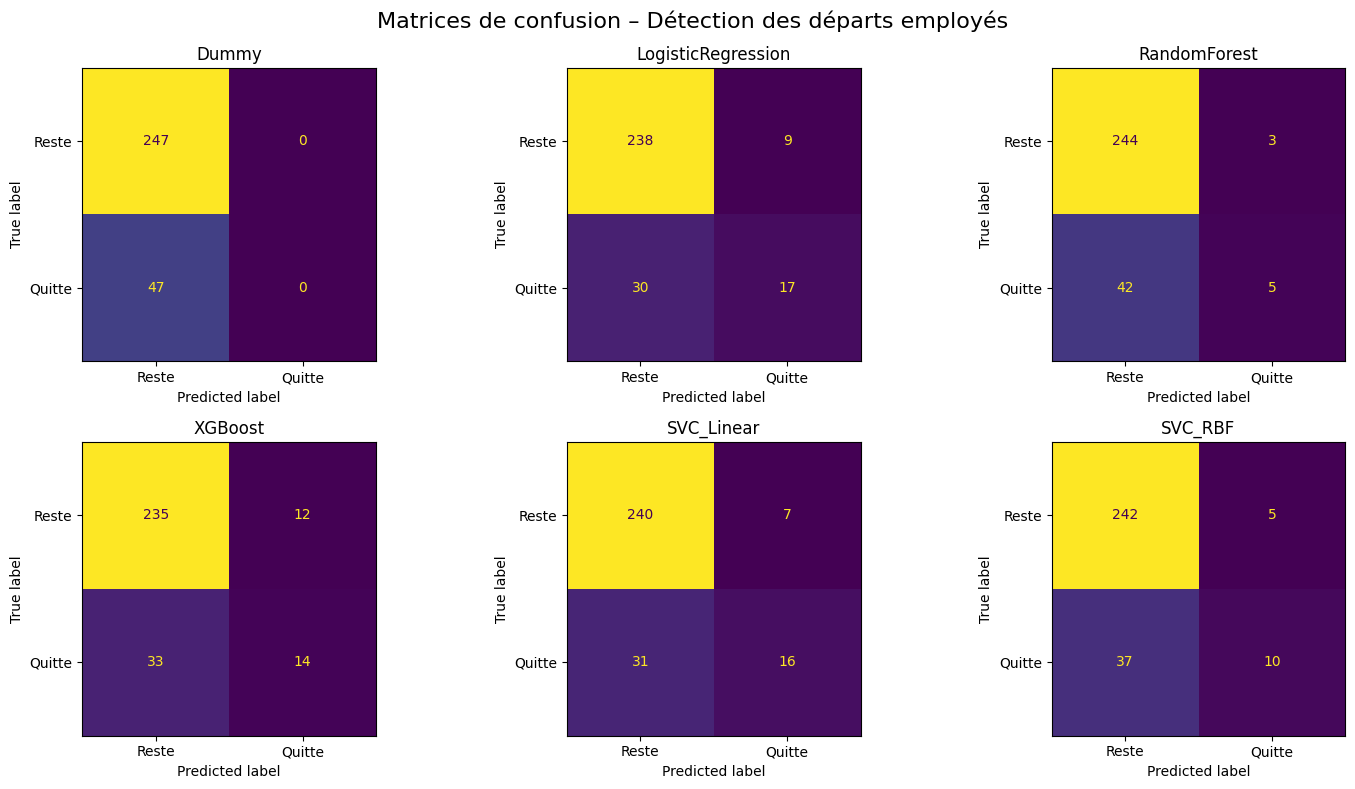

In [18]:
import matplotlib.pyplot as plt

# On importe les outils pour calculer et afficher une matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# On crée une figure contenant 2 lignes et 3 colonnes de graphiques, figsize définit la taille globale de la figure
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# On transforme la grille (2x3) en une liste simple d'axes, cela facilite la boucle sur chaque graphique
axes = axes.flatten()

# On parcourt en même temps :
# - chaque zone de dessin (ax)
# - chaque modèle du dictionnaire "models"
for ax, (name, model) in zip(axes, models.items()):
    # On entraîne le modèle avec les données d'entraînement
    model.fit(X_train, y_train)
    # Le modèle fait des prédictions sur les données de test
    y_pred = model.predict(X_test)

    # On calcule la matrice de confusion, elle compare les vraies valeurs aux valeurs prédites
    cm = confusion_matrix(y_test, y_pred)

    # On crée un objet pour afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(
        # Matrice de confusion calculée
        confusion_matrix=cm,
        # Noms lisibles des classes
        display_labels=["Reste", "Quitte"]
    )
    # On affiche la matrice dans le graphique courant. colorbar=False enlève la barre de couleurs pour plus de clarté
    disp.plot(ax=ax, colorbar=False)

    # On ajoute le nom du modèle comme titre du graphique
    ax.set_title(name)

# On ajoute un titre général à toute la figure
plt.suptitle("Matrices de confusion – Détection des départs employés", fontsize=16)
# Ajuste automatiquement les espacements pour éviter les chevauchements
plt.tight_layout()
# Affiche la figure finale
plt.show()


Une matrice de confusion est un outil d’évaluation qui permet d’analyser en détail les performances d’un modèle de classification. Contrairement à une simple métrique globale comme l’accuracy, elle montre précisément comment le modèle se trompe et sur quelles classes.

Elle compare les valeurs réelles aux valeurs prédites et permet d’identifier quatre cas possibles :
- les prédictions correctes
- les erreurs de classification
- les faux positifs
- et les faux négatifs

Dans le cadre de la détection des départs d’employés, la matrice de confusion est particulièrement importante car l’erreur la plus coûteuse est le faux négatif : un employé qui quitte l’entreprise mais que le modèle prédit comme restant. L’objectif principal est donc de détecter un maximum de départs réels, même si cela entraîne quelques erreurs sur les employés qui restent.

**Interprétation des matrices de confusion :**  

Le modèle de référence, le DummyClassifier, prédit systématiquement que tous les employés restent dans l’entreprise. Il obtient ainsi de bons résultats sur la classe majoritaire, mais il ne détecte aucun départ. Ce modèle n’a aucune valeur prédictive réelle et sert uniquement de baseline pour vérifier que les autres modèles font mieux qu’une stratégie naïve.

La régression logistique montre une amélioration nette. Elle parvient à détecter une partie des départs réels, tout en conservant de bonnes performances sur les employés qui restent. Toutefois, un nombre encore important de départs ne sont pas identifiés, ce qui limite son efficacité dans un contexte où la prévention des départs est cruciale.

Le Random Forest affiche de très bonnes performances sur la prédiction des employés restant dans l’entreprise, mais il échoue presque totalement à détecter les départs. La majorité des employés qui quittent sont classés à tort comme restant. Malgré sa popularité, ce modèle s’avère peu adapté à ce problème précis.

Le modèle XGBoost obtient des résultats intermédiaires. Il détecte davantage de départs que le Random Forest, mais reste en dessous de la régression logistique et du SVM linéaire. Bien qu’il soit puissant, il nécessiterait probablement un ajustement plus fin des paramètres ou du seuil de décision pour être réellement performant dans ce contexte.

Le SVM linéaire présente des performances très proches de la régression logistique. Il offre un bon équilibre entre la détection des départs et la classification correcte des employés qui restent. Sa stabilité et sa capacité à bien généraliser en font un modèle pertinent pour ce type de données.

Enfin, le SVM avec noyau RBF ne montre pas d’amélioration par rapport à la version linéaire. Au contraire, il détecte moins de départs, ce qui suggère que la relation entre les variables est majoritairement linéaire et que la complexité supplémentaire du noyau RBF n’est pas nécessaire.

**Conclusion**

L’analyse des matrices de confusion montre que les modèles les plus adaptés à la détection des départs d’employés sont la régression logistique et le SVM linéaire, car ce sont ceux qui identifient le plus grand nombre de départs réels.
À l’inverse, des modèles comme le Random Forest ou le DummyClassifier, bien que performants sur la classe majoritaire, sont peu efficaces pour l’objectif métier principal.

Dans un contexte RH, où le coût d’un départ non anticipé est élevé, il est essentiel de privilégier des modèles maximisant le recall de la classe “Quitte”, même au détriment d’une légère baisse de précision globale.

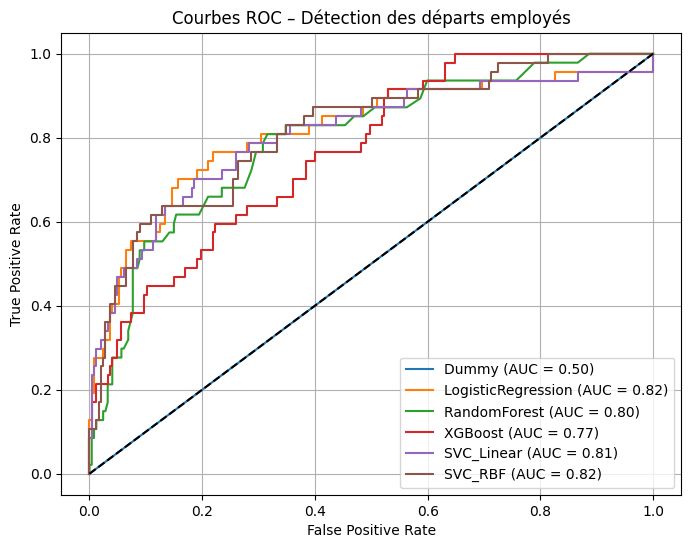

In [19]:
# On importe les fonctions nécessaires pour calculer la courbe ROC et l'AUC
from sklearn.metrics import roc_curve, auc

# On crée une nouvelle figure pour le graphique, figsize définit la taille de la figure
plt.figure(figsize=(8, 6))

# On parcourt chaque modèle du dictionnaire "models"
# name = nom du modèle
# model = pipeline du modèle
for name, model in models.items():
    # On entraîne le modèle avec les données d'entraînement
    model.fit(X_train, y_train)

    # Le modèle prédit la probabilité d'appartenir à la classe "Quitte". [:, 1] correspond à la probabilité de la classe positive
    y_proba = model.predict_proba(X_test)[:, 1]

    # On calcule les points de la courbe ROC
    # fpr : taux de faux positifs
    # tpr : taux de vrais positifs (recall)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # On calcule l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # On trace la courbe ROC du modèle, le label affiche le nom du modèle et sa valeur AUC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# On trace la diagonale correspondant à un modèle aléatoire, cette ligne sert de référence
plt.plot([0, 1], [0, 1], "k--")

# On ajoute le nom des axes
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# On ajoute un titre au graphique
plt.title("Courbes ROC – Détection des départs employés")
# On affiche la légende
plt.legend()
# On ajoute une grille pour faciliter la lecture
plt.grid(True)
# On affiche le graphique final
plt.show()

La courbe ROC (Receiver Operating Characteristic) est un outil d’évaluation qui permet d’analyser la capacité d’un modèle de classification à distinguer correctement deux classes, indépendamment d’un seuil de décision fixé. Elle représente, pour tous les seuils possibles, la relation entre le taux de vrais positifs (True Positive Rate, ou recall) et le taux de faux positifs (False Positive Rate).

L’intérêt principal de la courbe ROC est qu’elle ne dépend pas d’un choix arbitraire de seuil. Elle permet donc d’évaluer le potentiel global du modèle, même avant de décider à partir de quelle probabilité une prédiction est considérée comme positive. Cette approche est particulièrement pertinente dans des contextes où les classes sont déséquilibrées ou lorsque le coût des erreurs n’est pas symétrique, comme dans le cas de la détection des départs d’employés.

L’aire sous la courbe ROC, appelée AUC (Area Under the Curve), résume la performance du modèle en une seule valeur. Une AUC de 0,5 correspond à un modèle aléatoire, tandis qu’une AUC proche de 1 indique une excellente capacité de discrimination entre les deux classes. Plus l’AUC est élevée, plus le modèle est capable de classer correctement un employé qui quitte avant un employé qui reste.

**Interprétation des courbes ROC**  

Le DummyClassifier obtient une AUC de 0,50, ce qui confirme qu’il se comporte comme un modèle purement aléatoire. Il ne possède aucune capacité de discrimination et sert uniquement de référence minimale.

La régression logistique atteint une AUC d’environ 0,82, ce qui indique une très bonne capacité à distinguer les employés qui quittent de ceux qui restent. Sa courbe ROC est nettement au-dessus de la diagonale aléatoire sur l’ensemble des seuils, ce qui montre une performance stable et robuste.

Le Random Forest présente une AUC légèrement inférieure, autour de 0,80. Bien que ce score reste correct, il est moins performant que la régression logistique dans ce contexte. Cela confirme les observations issues des matrices de confusion, où ce modèle avait tendance à privilégier la classe majoritaire au détriment de la détection des départs.

Le modèle XGBoost obtient une AUC d’environ 0,77. Malgré sa puissance théorique, il se montre ici moins efficace pour discriminer les deux classes. Cela suggère que la complexité du modèle n’apporte pas de gain significatif sur ce jeu de données spécifique.

Le SVM linéaire atteint une AUC proche de 0,81, ce qui en fait l’un des meilleurs modèles testés. Sa performance est comparable à celle de la régression logistique, confirmant que la séparation entre les classes est majoritairement linéaire.

Enfin, le SVM avec noyau RBF obtient une AUC d’environ 0,82, très proche de la régression logistique. Cependant, comme observé précédemment avec les matrices de confusion, cette bonne performance globale ne se traduit pas nécessairement par une meilleure détection des départs au seuil de décision utilisé.

**Pourquoi utiliser les courbes ROC dans ce projet**

Les courbes ROC ont été utilisées dans ce projet pour plusieurs raisons. Tout d’abord, elles permettent de comparer les modèles de manière équitable, sans dépendre d’un seuil fixe qui pourrait favoriser artificiellement certains modèles. Ensuite, elles offrent une vision globale des performances, complémentaire aux matrices de confusion et aux métriques classiques comme le recall ou la précision.

Dans un contexte de ressources humaines, où l’objectif est d’anticiper les départs d’employés, il est essentiel de comprendre le compromis entre la détection des départs et les fausses alertes. La courbe ROC permet précisément d’analyser ce compromis et d’identifier les modèles offrant la meilleure capacité de discrimination.

Enfin, l’utilisation conjointe des courbes ROC, de l’AUC et des matrices de confusion permet de prendre une décision éclairée : un modèle peut avoir une bonne AUC mais rester peu adapté si, au seuil choisi, il ne détecte pas suffisamment de départs. Ces outils doivent donc être interprétés ensemble.

**Conclusion**

L’analyse des courbes ROC montre que la régression logistique, le SVM linéaire et le SVM RBF présentent les meilleures capacités globales de discrimination. Toutefois, en tenant compte des matrices de confusion et de l’objectif métier, la régression logistique et le SVM linéaire apparaissent comme les modèles les plus équilibrés et les plus pertinents pour la détection des départs d’employés.

-----------------------------------------------

# Correction du déséquilibre de classe

Classe 0 = reste (majoritaire)  

Classe 1 = quitte (minoritaire)

Sans correction :
- le modèle apprend surtout à prédire « reste »
- le recall de la classe « quitte » est pénalisé
- certains modèles (RF, SVC) deviennent trop conservateurs

Corriger le déséquilibre = améliorer la détection des départs.

### Avec pondération des classes

La pondération des classes constitue une alternative simple et robuste au sur-échantillonnage par SMOTE. Contrairement à SMOTE, elle ne modifie pas la distribution des données mais ajuste la fonction de perte afin de pénaliser davantage les erreurs commises sur la classe minoritaire.

Les résultats montrent que la pondération des classes permet d’améliorer significativement le recall des modèles linéaires (régression logistique, SVC linéaire), tout en conservant une bonne stabilité et une meilleure interprétabilité.

Comparée à SMOTE, cette approche présente l’avantage de réduire les risques de sur-apprentissage et de mieux préserver la structure originale des données. Dans un contexte RH, où la lisibilité du modèle est essentielle, la pondération des classes apparaît comme un excellent compromis entre performance prédictive et interprétabilité.

In [20]:
# # Pipelines avec pondération des classes

# pipe_logreg_weighted = Pipeline([
#     ("preprocess", preprocessor),
#     ("model", LogisticRegression(
#         max_iter=1000,
#         class_weight="balanced"
#     ))
# ])

# pipe_rf_weighted = Pipeline([
#     ("preprocess", preprocessor),
#     ("model", RandomForestClassifier(
#         n_estimators=300,
#         random_state=42,
#         class_weight="balanced"
#     ))
# ])

# pipe_svc_linear_weighted = Pipeline([
#     ("preprocess", preprocessor),
#     ("model", SVC(
#         kernel="linear",
#         probability=True,
#         class_weight="balanced"
#     ))
# ])

# pipe_svc_rbf_weighted = Pipeline([
#     ("preprocess", preprocessor),
#     ("model", SVC(
#         kernel="rbf",
#         probability=True,
#         class_weight="balanced"
#     ))
# ])

# scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
# pipe_xgb_weighted = Pipeline([
#     ("preprocess", preprocessor),
#     ("model", XGBClassifier(
#         eval_metric="logloss",
#         random_state=42,
#         scale_pos_weight=scale_pos_weight
#     ))
# ])



In [21]:
# models_weighted = {
#     "LogisticRegression": pipe_logreg_weighted,
#     "RandomForest": pipe_rf_weighted,
#     "XGBoost": pipe_xgb_weighted,
#     "SVC_Linear": pipe_svc_linear_weighted,
#     "SVC_RBF": pipe_svc_rbf_weighted
# }

Cross-validation (recall)

In [22]:
# for name, model in models_weighted.items():
#     scores = cross_val_score(
#         model, X, y,
#         cv=5,
#         scoring="recall"
#     )
#     print(f"{name} (class_weight) Recall: {scores.mean():.3f}")

Evaluation train / test

In [23]:
# results_weighted = {}

# for name, model in models_weighted.items():
#     results_weighted[name] = evaluate_model(
#         model,
#         X_train, X_test,
#         y_train, y_test
#     )

# results_weighted_df = pd.DataFrame(results_weighted).T
# results_weighted_df

### Avec SMOTE

Afin de corriger le déséquilibre de classes et améliorer la détection des départs d’employés, une stratégie de sur-échantillonnage de la classe minoritaire (SMOTE) a été intégrée au pipeline de modélisation. Cette approche permet d’entraîner les modèles sur des données équilibrées tout en évitant toute fuite d’information grâce à son intégration dans la validation croisée.

Dans le cadre de ce projet, l’objectif principal est de prédire les départs d’employés afin de permettre aux équipes de ressources humaines d’anticiper les risques d’attrition et de mettre en place des actions de rétention. La variable cible présente toutefois un déséquilibre marqué : la majorité des employés restent dans l’entreprise, tandis qu’une proportion nettement plus faible la quitte. Ce déséquilibre pose un problème majeur pour les modèles de classification supervisée, qui tendent naturellement à privilégier la classe majoritaire au détriment de la classe minoritaire.

En l’absence de correction, les modèles obtiennent des scores d’accuracy élevés mais présentent une capacité très limitée à détecter les départs, comme en témoignent les faibles valeurs de rappel (recall). Or, dans un contexte RH, un faux négatif (c’est-à-dire un employé à risque non identifié) est bien plus coûteux qu’un faux positif. Il était donc nécessaire d’adopter une stratégie visant à améliorer la représentation de la classe « départ » dans les données d’entraînement.

La méthode retenue est SMOTE (Synthetic Minority Over-sampling Technique). Contrairement à un sur-échantillonnage naïf consistant à dupliquer les observations de la classe minoritaire, SMOTE génère de nouvelles observations synthétiques à partir des données existantes. Pour chaque observation appartenant à la classe minoritaire, l’algorithme identifie ses plus proches voisins et crée de nouveaux points situés entre ces observations dans l’espace des caractéristiques. Les profils générés sont ainsi réalistes et cohérents avec les données observées, tout en apportant de la diversité supplémentaire à la classe minoritaire.

L’intérêt principal de SMOTE réside dans sa capacité à enrichir l’espace de décision des modèles. En exposant les algorithmes à une plus grande variété de profils d’employés quittant l’entreprise, la frontière de décision devient plus précise et moins biaisée en faveur de la classe majoritaire. Cette approche améliore significativement la détection des départs, ce qui se traduit par une augmentation notable du rappel, tout en limitant les risques de sur-apprentissage associés à la simple duplication des données.

Dans ce projet, SMOTE a été intégré directement au sein du pipeline de modélisation, en amont de l’entraînement des modèles et dans le cadre de la validation croisée. Cette intégration garantit que le sur-échantillonnage est appliqué uniquement aux jeux d’entraînement de chaque fold, évitant ainsi toute fuite d’information vers les données de validation ou de test. Cette précaution est essentielle pour obtenir une évaluation réaliste et fiable des performances.

Le choix de SMOTE est particulièrement pertinent dans le contexte de la prédiction de l’attrition des employés. Les départs sont généralement le résultat d’une combinaison de facteurs (rémunération, ancienneté, conditions de travail, reconnaissance, etc.) plutôt que d’un critère unique. Les profils à risque sont donc variés et continus, ce qui correspond bien à l’hypothèse sous-jacente de SMOTE, fondée sur la création de nouveaux points intermédiaires entre observations similaires.

En conclusion, l’utilisation de SMOTE répond à un double objectif méthodologique et métier : corriger efficacement le déséquilibre de classes afin d’améliorer la capacité des modèles à détecter les départs d’employés, tout en conservant une approche rigoureuse, sans fuite d’information, compatible avec une validation croisée et une optimisation des hyperparamètres. Cette méthode permet ainsi de mieux aligner les performances des modèles avec les enjeux opérationnels des ressources humaines, où la priorité est donnée à l’anticipation des départs plutôt qu’à une simple maximisation de l’accuracy globale.

In [24]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

Nouveaux pipelines avec SMOTE

In [25]:
# On utilise ImbPipeline (pipeline d'imblearn). Contrairement au Pipeline classique, il permet d'intégrer des techniques de rééquilibrage des classes comme SMOTE

# Pipeline Regression logistique avec SMOTE
pipe_logreg_smote = ImbPipeline([
    # Étape 1 : prétraitement des données (nettoyage et transformation des variables (imputation, encodage, normalisation))
    ("preprocess", preprocessor),
    # Étape 2 : SMOTE, crée artificiellement de nouveaux exemples de la classe minoritaire. Ici, la classe "Quitte" pour rééquilibrer le jeu de données
    ("smote", SMOTE(random_state=42)),
    # Étape 3 : modèle de régression logistique (modèle linéaire de classification)
    ("model", LogisticRegression(max_iter=1000))
])

# Pipeline Random Forest avec SMOTE
pipe_rf_smote = ImbPipeline([
    # Prétraitement des données
    ("preprocess", preprocessor),
    # Rééquilibrage des classes avec SMOTE
    ("smote", SMOTE(random_state=42)),
    # Modèle Random Forest
    ("model", RandomForestClassifier(random_state=42))
])

# Pipeline XGBoost avec SMOTE
pipe_xgb_smote = ImbPipeline([
    # Prétraitement des données
    ("preprocess", preprocessor),
    # Rééquilibrage des classes avec SMOTE
    ("smote", SMOTE(random_state=42)),
    # Modèle XGBoost
    ("model", XGBClassifier(
        # Fonction de perte adaptée à la classification
        eval_metric="logloss",
        # Assure la reproductibilité
        random_state=42
    ))
])

# Pipeline SVM linéaire avec SMOTE
pipe_svc_linear_smote = ImbPipeline([
    # Prétraitement des données
    ("preprocess", preprocessor),
    # Rééquilibrage des classes avec SMOTE
    ("smote", SMOTE(random_state=42)),
    # Modèle SVM avec noyau linéaire
    ("model", SVC(kernel="linear", probability=True))
])

# Pipeline SVM avec noyau RBF et SMOTE
pipe_svc_rbf_smote = ImbPipeline([
    # Prétraitement des données
    ("preprocess", preprocessor),
    # Rééquilibrage des classes avec SMOTE
    ("smote", SMOTE(random_state=42)),
    # Modèle SVM avec noyau non linéaire (RBF)
    ("model", SVC(kernel="rbf", probability=True))
])

In [26]:
models_smote = {
    "LogisticRegression": pipe_logreg_smote,
    "RandomForest": pipe_rf_smote,
    "XGBoost": pipe_xgb_smote,
    "SVC_Linear": pipe_svc_linear_smote,
    "SVC_RBF": pipe_svc_rbf_smote
}

# Grilles d’hyperparamètres

### Régression Logistique

**C**  

C contrôle la force de la régularisation, c’est-à-dire à quel point le modèle est autorisé à être complexe.

Petit C (ex : 0.01)  
- le modèle est très contraint  
- il évite les décisions trop complexes  
- risque de sous-apprentissage  

Grand C (ex : 10)  
- le modèle est plus libre  
- il s’adapte davantage aux données  
- risque de sur-apprentissage  

C règle l’équilibre entre simplicité et précision du modèle.  

**L1 ratio**  

Ce paramètre définit le type de pénalisation appliquée au modèle lorsqu’on utilise une régularisation élastique (mélange L1 et L2).

l1_ratio = 0
- uniquement régularisation L2
- toutes les variables sont conservées, mais leurs coefficients sont réduits

Dans notre cas, comme l1_ratio est fixé à 0, le modèle utilise uniquement une régularisation L2, ce qui est un choix classique et stable.  

**solver**  

Le solver est l’algorithme mathématique utilisé pour trouver les meilleurs coefficients du modèle.

"lbfgs"
- rapide
- stable
- bien adapté aux jeux de données de taille moyenne
- compatible avec la régularisation L2

En pratique, "lbfgs" est un choix par défaut très fiable pour la régression logistique.

**class weight**  

Ce paramètre permet de gérer le déséquilibre entre les classes.

None
- toutes les observations ont le même poids
- le modèle favorise la classe majoritaire

"balanced"
- les classes rares ont plus d’importance
- le modèle fait plus attention à la classe minoritaire

C’est particulièrement utile lorsque :
- une classe est beaucoup plus rare que l’autre
- on veut améliorer le recall de la classe minoritaire

In [27]:
param_grid_logreg = {
    "model__C": [0.01, 0.1, 1, 10],                 # Paramètre de régularisation : plus C est grand, moins la régularisation est forte
    "model__l1_ratio": [0],                         # Ratio L1/L2 (ici fixé à 0 : uniquement L2)
    "model__solver": ["lbfgs"],                     # Algorithme d'optimisation utilisé par la régression logistique
    "model__class_weight": [None, "balanced"]       # Gestion du déséquilibre des classes (balanced ajuste automatiquement les poids)
}

### Random Forest

**n estimators**  

n_estimators définit le nombre d’arbres dans la forêt.
- peu d’arbres : modèle instable
- beaucoup d’arbres : décisions plus fiables

Chaque arbre peut se tromper, mais ensemble ils se corrigent.

Effet quand on change la valeur : 
* Petit nombre (ex : 50)
    - rapide
    - mais prédictions moins robustes
* Grand nombre (ex : 500)
    - plus stable
    - plus précis
    - plus lent à entraîner

Augmenter n_estimators améliore souvent les performances jusqu’à un certain point.

**max depth**  

max_depth fixe la profondeur maximale de chaque arbre.  

La profondeur correspond au nombre de décisions successives :
- arbre peu profond : décisions simples
- arbre très profond : décisions très spécifiques

Effet quand on change la valeur
* Faible profondeur (ex : 5–10)
    - arbre simple
    - moins de sur-apprentissage
    - peut manquer de précision
* Grande profondeur ou None
    - arbre très complexe
    - apprend des détails très fins
    - risque de sur-apprentissage

max_depth contrôle la complexité des arbres.

**min samples split**  

Ce paramètre indique le nombre minimum d’observations nécessaires pour séparer un nœud.  

Avant de poser une nouvelle question dans l’arbre, on vérifie : “Ai-je assez de données pour que cette décision ait du sens ?”

* Valeur basse (ex : 2)
    - l’arbre se sépare très facilement
    - très détaillé
    - risque de sur-apprentissage
* Valeur élevée (ex : 10)
    - séparation plus difficile
    - arbre plus simple
    - meilleure généralisation

Plus min_samples_split est grand, plus l’arbre est prudent.


In [28]:
param_grid_rf = {
    "model__n_estimators": [200, 500],              # Nombre d'arbres dans la forêt
    "model__max_depth": [None, 10, 20],             # Profondeur maximale des arbres (None = pas de limite)
    "model__min_samples_split": [2, 10],            # Nombre minimum d'échantillons pour séparer un nœud
    "model__class_weight": [None, "balanced"]       # Pondération des classes pour gérer le déséquilibre
}

### XGBoost

**learning rate**  

Le learning_rate contrôle l’importance de chaque nouvel arbre ajouté au modèle.

À chaque nouvel arbre, on demande : “À quel point ce nouvel arbre peut-il corriger les erreurs ?”

* Grand learning rate
    - chaque arbre corrige beaucoup
    - apprentissage rapide
    - risque de sur-apprentissage
* Petit learning rate
    - chaque arbre corrige un peu
    - apprentissage plus lent
    - modèle plus stable

Exemple :  
- learning_rate = 0.3 → gros pas
- learning_rate = 0.05 → petits pas très prudents

En pratique : petit learning rate + plus d’arbres = meilleur modèle

**subsample**  

subsample indique quelle proportion des données est utilisée pour entraîner chaque arbre.

Au lieu d’utiliser toutes les données à chaque arbre, on en prend une partie au hasard. Cela force les arbres à être :
- un peu différents
- moins dépendants du bruit

Effet des valeurs :
* subsample = 1.0
    - toutes les données
    - apprentissage plus précis
    - risque de sur-apprentissage
* subsample = 0.8
    - 80 % des données
    - plus de diversité
    - meilleure généralisation

Très similaire à l’idée du Random Forest.

**scale pos weight**  

Ce paramètre sert à corriger le déséquilibre entre les classes.

Si une classe est rare, le modèle peut l’ignorer.

scale_pos_weight dit au modèle : “Attention, cette classe est importante, pénalise plus fortement ses erreurs.”

Valeurs typiques
* 1
    - pas de pondération
    - toutes les erreurs ont le même poids
* nb_negatifs / nb_positifs
    - erreurs sur la classe minoritaire beaucoup plus pénalisées

Cela revient à dire : “La classe positive est X fois plus rare, donc ses erreurs comptent X fois plus.”


In [29]:
param_grid_xgb = {
    "model__max_depth": [3, 5, 7],                                                  # Profondeur maximale des arbres
    "model__learning_rate": [0.05, 0.1],                                            # Taux d'apprentissage (plus petit = apprentissage plus lent mais souvent plus stable)
    "model__n_estimators": [200, 500],                                              # Nombre d'arbres
    "model__subsample": [0.8, 1.0],                                                 # Proportion des données utilisées pour chaque arbre
    "model__scale_pos_weight": [1, (y_train == 0).sum() / (y_train == 1).sum()]     # Pondération automatique basée sur le déséquilibre des classes
}

### SVC Linéaire

In [30]:
param_grid_svc_linear = {
    "model__C": [0.01, 0.1, 1, 10],                 # Paramètre de régularisation du SVM
    "model__class_weight": [None, "balanced"]       # Ajustement des poids des classes
}

### SVC RBF

**gamma**  

gamma contrôle l’influence d’un point de données sur la frontière de décision.

Autrement dit : “Jusqu’où un point peut-il influencer la forme de la frontière ?”

Il faut imaginer que chaque point crée une zone d’influence autour de lui, gamma détermine la taille de cette zone : 
* Petit gamma (ex : 0.01)
    - chaque point influence une grande zone
    - la frontière est lisse et simple
    - le modèle regarde la structure globale

Effet :
- moins de sur-apprentissage
- risque de sous-apprentissage

* Grand gamma (ex : 1 ou plus)
    - chaque point influence une zone très petite
    - la frontière devient très sinueuse
    - le modèle s’adapte aux détails

Effet :
- très bonne performance sur le train
- fort risque de sur-apprentissage

Le cas spécial : gamma = "scale"

"scale" est une valeur automatique calculée à partir des données :

gamma = 1 / (nombre_de_features × variance_des_features)

Avantages :
- s’adapte automatiquement à l’échelle des données
- très bon choix par défaut
- évite des valeurs trop extrêmes

Relation avec C
- gamma ne travaille jamais seul.
- C contrôle la tolérance aux erreurs
- gamma contrôle la forme de la frontière

In [31]:
param_grid_svc_rbf = {
    "model__C": [0.1, 1, 10],                       # Paramètre de régularisation
    "model__gamma": ["scale", 0.01, 0.1],           # Influence d'un point sur la frontière de décision
    "model__class_weight": [None, "balanced"]       # Gestion du déséquilibre des classes
}

**Lancement des GridSearchCV**  

Le GridSearchCV est une méthode utilisée en apprentissage automatique pour trouver automatiquement les meilleurs paramètres d’un modèle. En pratique, beaucoup de modèles possèdent des hyperparamètres (par exemple la profondeur d’un arbre, le nombre de voisins en k-NN, le paramètre C d’une régression logistique) qui influencent fortement leurs performances. Le problème est de savoir quelles valeurs choisir.

Le principe du GridSearchCV consiste à tester systématiquement toutes les combinaisons possibles de valeurs d’hyperparamètres définies à l’avance par l’utilisateur. Pour chaque combinaison, le modèle est entraîné et évalué à l’aide de la cross-validation, ce qui permet d’obtenir une mesure de performance fiable.

Concrètement, on définit :

un modèle (par exemple une régression logistique),

une grille de paramètres (par exemple plusieurs valeurs possibles pour C et pour le type de régularisation),

une méthode d’évaluation (accuracy, F1-score, etc.).

GridSearchCV va alors entraîner le modèle pour chaque combinaison de paramètres, effectuer une validation croisée pour chacune d’elles, puis comparer les scores moyens obtenus. À la fin, il sélectionne automatiquement la combinaison de paramètres qui donne les meilleures performances.

L’intérêt principal du GridSearchCV est qu’il automatise et fiabilise le choix des hyperparamètres. Au lieu de tester les paramètres manuellement ou au hasard, il explore l’espace des possibilités de façon méthodique tout en évitant le sur-apprentissage grâce à la cross-validation.

En résumé, GridSearchCV permet de trouver les meilleurs hyperparamètres d’un modèle en testant toutes les combinaisons possibles, chacune évaluée par validation croisée, afin d’obtenir un modèle à la fois performant et robuste.

In [32]:
param_grids_smote = {
    "LogisticRegression": param_grid_logreg,        # Grille pour la régression logistique
    "RandomForest": param_grid_rf,                  # Grille pour le Random Forest
    "XGBoost": param_grid_xgb,                      # Grille pour XGBoost
    "SVC_Linear": param_grid_svc_linear,            # Grille pour le SVM linéaire
    "SVC_RBF": param_grid_svc_rbf                   # Grille pour le SVM RBF
}

**Cross-validation (recall)**

La cross-validation, ou validation croisée, est une méthode utilisée en apprentissage automatique pour évaluer la performance d’un modèle de manière plus fiable. Son objectif est de vérifier que le modèle fonctionne bien non seulement sur les données utilisées pour l’entraîner, mais aussi sur de nouvelles données qu’il n’a jamais vues.

Le principe consiste à diviser l’ensemble des données en plusieurs sous-ensembles. Le modèle est alors entraîné plusieurs fois : à chaque itération, une partie des données est utilisée pour le test, tandis que les autres servent à l’entraînement. Cette opération est répétée jusqu’à ce que chaque sous-ensemble ait été utilisé une fois comme jeu de test. Les performances obtenues à chaque étape sont ensuite moyennées pour donner une estimation globale de la qualité du modèle.

Cette méthode permet de limiter le risque de sur-apprentissage, c’est-à-dire le cas où un modèle apprend trop précisément les données d’entraînement sans être capable de généraliser. Elle fournit également une évaluation plus robuste et plus représentative que le simple découpage des données en un seul jeu d’entraînement et un seul jeu de test.

En résumé, la cross-validation est une technique qui consiste à tester un modèle sur différentes portions des données afin de s’assurer qu’il est réellement performant et capable de bien généraliser.

In [33]:
# Importation du GridSearchCV (outil pour tester plusieurs hyperparamètres avec validation croisée)
from sklearn.model_selection import GridSearchCV

# Dictionnaire qui contiendra pour chaque modèle la meilleure version (meilleurs hyperparamètres)
best_models_smote = {}
# Dictionnaire qui contiendra pour chaque modèle l'objet GridSearchCV complet (pour analyser ensuite)
grid_results_smote = {}

# On parcourt les noms de tous les modèles présents dans le dictionnaire models_smote
for name in models_smote.keys():
    # On affiche une ligne de séparation pour rendre la sortie plus lisible
    print("=" * 70)
    # On affiche quel modèle est en cours d'optimisation
    print(f"GridSearchCV avec SMOTE – {name}")

    # On crée un objet GridSearchCV
    grid = GridSearchCV(
        estimator=models_smote[name],           # Le modèle à optimiser correspondant au nom "name"
        param_grid=param_grids_smote[name],     # La grille des hyperparamètres à tester pour ce modèle (toutes les combinaisons seront évaluées)
        scoring="recall",                       # Le score qu'on veut maximiser : ici le recall (rappel), utile en cas de classes déséquilibrées
        cv=5,                                   # Nombre de folds pour la cross-validation : on fait 5 découpages train/test
        n_jobs=-1,                              # Utilise tous les cœurs du processeur pour accélérer (parallélisation)
        verbose=0                               # Niveau de détails affichés pendant le calcul (0 = silencieux)
    )

    # On lance l'entraînement + la recherche : GridSearchCV teste toutes les combinaisons sur X_train/y_train
    grid.fit(X_train, y_train)

    # On affiche le meilleur recall moyen obtenu en cross-validation
    print(f"Meilleur recall (CV) : {grid.best_score_:.3f}")
    # On affiche les hyperparamètres qui ont donné ce meilleur résultat
    print("Meilleurs hyperparamètres :", grid.best_params_)

    # On enregistre le meilleur modèle (déjà ré-entraîné avec les meilleurs paramètres)
    best_models_smote[name] = grid.best_estimator_
    # On enregistre l'objet GridSearchCV complet (utile pour consulter tous les scores)
    grid_results_smote[name] = grid

GridSearchCV avec SMOTE – LogisticRegression
Meilleur recall (CV) : 0.758
Meilleurs hyperparamètres : {'model__C': 0.1, 'model__class_weight': None, 'model__l1_ratio': 0, 'model__solver': 'lbfgs'}
GridSearchCV avec SMOTE – RandomForest
Meilleur recall (CV) : 0.389
Meilleurs hyperparamètres : {'model__class_weight': None, 'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 500}
GridSearchCV avec SMOTE – XGBoost
Meilleur recall (CV) : 0.684
Meilleurs hyperparamètres : {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': np.float64(5.189473684210526), 'model__subsample': 1.0}
GridSearchCV avec SMOTE – SVC_Linear
Meilleur recall (CV) : 0.753
Meilleurs hyperparamètres : {'model__C': 0.01, 'model__class_weight': None}
GridSearchCV avec SMOTE – SVC_RBF
Meilleur recall (CV) : 0.753
Meilleurs hyperparamètres : {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 0.01}


**Interprétation des résultats du GridSearchCV avec SMOTE**

Le GridSearchCV a été utilisé afin d’optimiser les hyperparamètres de plusieurs modèles de classification en intégrant la technique SMOTE pour corriger le déséquilibre des classes. L’objectif principal de cette optimisation était de maximiser le recall de la classe “Quitte”, car dans un contexte de ressources humaines, rater un départ réel est plus coûteux qu’une fausse alerte.

Les scores présentés correspondent au meilleur recall moyen obtenu en validation croisée, ce qui garantit une évaluation robuste et moins sensible au découpage des données.

**Régression logistique avec SMOTE**

La régression logistique obtient le meilleur recall moyen en validation croisée, avec une valeur de 0,758. Ce résultat signifie que le modèle parvient à détecter environ 76 % des départs réels lors de la validation croisée, ce qui est particulièrement satisfaisant dans un contexte de prévention du turnover.

Les meilleurs hyperparamètres indiquent une valeur de C = 0,1, ce qui correspond à une régularisation relativement forte. Cela montre que le modèle bénéficie d’une simplification, évitant le sur-apprentissage tout en conservant une bonne capacité de généralisation. L’absence de pondération des classes (class_weight=None) suggère que SMOTE suffit à rééquilibrer les données, rendant inutile une correction supplémentaire.

Globalement, cette configuration offre un excellent compromis entre performance, stabilité et interprétabilité.

**Random Forest avec SMOTE**

Le Random Forest présente un recall nettement plus faible, avec une valeur de 0,389. Malgré l’utilisation de SMOTE, le modèle reste peu efficace pour détecter les départs, ce qui confirme les observations précédentes issues des matrices de confusion et des courbes ROC.

Les hyperparamètres optimaux montrent une profondeur maximale limitée (max_depth = 10) et un nombre élevé d’arbres (n_estimators = 500), ce qui vise à stabiliser le modèle. Cependant, même optimisé, le Random Forest demeure fortement biaisé vers la classe majoritaire et s’avère mal adapté à cet objectif métier précis.

**XGBoost avec SMOTE**

Le modèle XGBoost atteint un recall intermédiaire de 0,684. Bien que ce score soit inférieur à celui de la régression logistique et des SVM, il reste significativement supérieur à celui du Random Forest.

Les hyperparamètres retenus montrent une approche prudente :
- un learning rate faible (0,05),
- une profondeur d’arbre limitée (3),
- et une pondération explicite de la classe minoritaire via scale_pos_weight.

Cela indique que XGBoost est capable d’apprendre des patterns pertinents, mais que sa complexité n’apporte pas de gain décisif par rapport à des modèles plus simples dans ce cas précis.

**SVM linéaire avec SMOTE**

Le SVM linéaire obtient un excellent recall de 0,753, très proche de celui de la régression logistique. Ce résultat confirme que la séparation entre les classes est en grande partie linéaire, et que des modèles simples et robustes sont bien adaptés à ce problème.

La valeur très faible de C = 0,01 indique une forte régularisation, favorisant la généralisation et réduisant la sensibilité au bruit. Comme pour la régression logistique, aucune pondération des classes n’est nécessaire, SMOTE jouant pleinement son rôle.

**SVM avec noyau RBF et SMOTE**

Le SVM RBF atteint également un recall de 0,753, équivalent à celui du SVM linéaire. Cependant, l’ajout d’un noyau non linéaire n’apporte pas de gain supplémentaire, malgré des hyperparamètres ajustés (C = 0,1, gamma = 0,01).

Cela suggère que la complexité introduite par le noyau RBF n’est pas nécessaire et peut même être superflue dans ce contexte, où les relations entre variables et probabilité de départ sont majoritairement linéaires.

**Comparaison globale des modèles**

En termes de recall moyen en validation croisée :
- Régression logistique : 0,758
- SVM linéaire : 0,753
- SVM RBF : 0,753
- XGBoost : 0,684
- Random Forest : 0,389

Les résultats montrent clairement que les modèles linéaires surpassent les modèles plus complexes pour la détection des départs d’employés dans ce projet.

**Conclusion**

L’optimisation par GridSearchCV avec SMOTE met en évidence que la régression logistique est le modèle le plus performant pour maximiser le recall de la classe “Quitte”, tout en restant simple, stable et interprétable. Le SVM linéaire constitue une excellente alternative, offrant des performances très proches.

À l’inverse, le Random Forest s’avère inadapté à l’objectif métier malgré l’utilisation de SMOTE, tandis que XGBoost et le SVM RBF n’apportent pas d’amélioration suffisante pour justifier leur complexité supplémentaire.

Ces résultats confirment que, dans un contexte RH orienté prévention du turnover, il est préférable de privilégier des modèles simples, bien régularisés et interprétables, capables de détecter efficacement les employés à risque.

In [34]:
# param_grids_weighted = {
#     "LogisticRegression": param_grid_logreg,
#     "RandomForest": param_grid_rf,
#     "XGBoost": param_grid_xgb,
#     "SVC_Linear": param_grid_svc_linear,
#     "SVC_RBF": param_grid_svc_rbf
# }

In [35]:
# from sklearn.model_selection import GridSearchCV

# best_models_weighted = {}
# grid_results_weighted = {}

# for name in models_weighted.keys():
#     print("=" * 70)
#     print(f"GridSearchCV avec pondération des classes – {name}")

#     grid = GridSearchCV(
#         estimator=models_weighted[name],
#         param_grid=param_grids_weighted[name],
#         scoring="recall",
#         cv=5,
#         n_jobs=-1,
#         verbose=1
#     )

#     grid.fit(X_train, y_train)

#     print(f"Meilleur recall (CV) : {grid.best_score_:.3f}")
#     print("Meilleurs hyperparamètres :", grid.best_params_)

#     best_models_weighted[name] = grid.best_estimator_
#     grid_results_weighted[name] = grid

Évaluation des modèles SMOTE optimisés

In [36]:
# On crée un dictionnaire vide, il servira à stocker les résultats des modèles utilisant SMOTE
results_smote = {}

# On parcourt chaque modèle du dictionnaire "best_models_smote"
# name = nom du modèle
# model = pipeline du modèle (prétraitement + SMOTE + modèle)
for name, model in best_models_smote.items():
    # On évalue le modèle avec la fonction evaluate_model, cette fonction entraîne le modèle et calcule plusieurs métriques
    results_smote[name] = evaluate_model(
        # Le pipeline du modèle à évaluer
        model,
        # Données d'entraînement et de test
        X_train, X_test,
        y_train, y_test
    )

# On transforme le dictionnaire de résultats en DataFrame pandas, chaque ligne correspond à un modèle et chaque colonne correspond à une métrique
results_smote_df = pd.DataFrame(results_smote).T
# On affiche le tableau final des résultats avec SMOTE
results_smote_df

,Accuracy,Precision,Recall,F1,AUC
LogisticRegression,0.792517,0.412500,0.702128,0.519685,0.815746
RandomForest,0.836735,0.478261,0.234043,0.314286,0.791455
XGBoost,0.768707,0.363636,0.595745,0.451613,0.774658
SVC_Linear,0.778912,0.392857,0.702128,0.503817,0.807692
SVC_RBF,0.734694,0.352381,0.787234,0.486842,0.799595


Évaluation des modèles pondéré par classe optimisés

In [37]:
# results_weighted = {}

# for name, model in best_models_weighted.items():
#     results_weighted[name] = evaluate_model(
#         model,
#         X_train, X_test,
#         y_train, y_test
#     )

# results_weighted = pd.DataFrame(results_weighted).T
# results_weighted_df


Les hyperparamètres ont été optimisés via une validation croisée en maximisant le recall, afin de réduire le nombre de départs non anticipés.

Comparaison avant/après SMOTE

In [38]:
comparison_df = pd.concat(
    [results_df, results_smote_df],
    keys=["Sans SMOTE", "Avec SMOTE"]
)

comparison_df

Accuracy  Precision    Recall        F1  \
Sans SMOTE Dummy               0.840136   0.000000  0.000000  0.000000   
           LogisticRegression  0.867347   0.653846  0.361702  0.465753   
           RandomForest        0.846939   0.625000  0.106383  0.181818   
           XGBoost             0.846939   0.538462  0.297872  0.383562   
           SVC_Linear          0.870748   0.695652  0.340426  0.457143   
           SVC_RBF             0.857143   0.666667  0.212766  0.322581   
Avec SMOTE LogisticRegression  0.792517   0.412500  0.702128  0.519685   
           RandomForest        0.836735   0.478261  0.234043  0.314286   
           XGBoost             0.768707   0.363636  0.595745  0.451613   
           SVC_Linear          0.778912   0.392857  0.702128  0.503817   
           SVC_RBF             0.734694   0.352381  0.787234  0.486842   

                                    AUC  
Sans SMOTE Dummy               0.500000  
           LogisticRegression  0.815402  
           RandomForest        0.795762  
           XGBoost             0.767594  
           SVC_Linear          0.807219  
           SVC_RBF             0.816694  
Avec SMOTE LogisticRegression  0.815746  
           RandomForest        0.791455  
           XGBoost             0.774658  
           SVC_Linear          0.807692  
           SVC_RBF             0.799595

In [39]:
# comparison_df = pd.concat(
#     [results_df, results_weighted_df],
#     keys=["Sans pondération des classes", "Avec pondération des classes"]
# )

# comparison_df

### Matrice de confusion

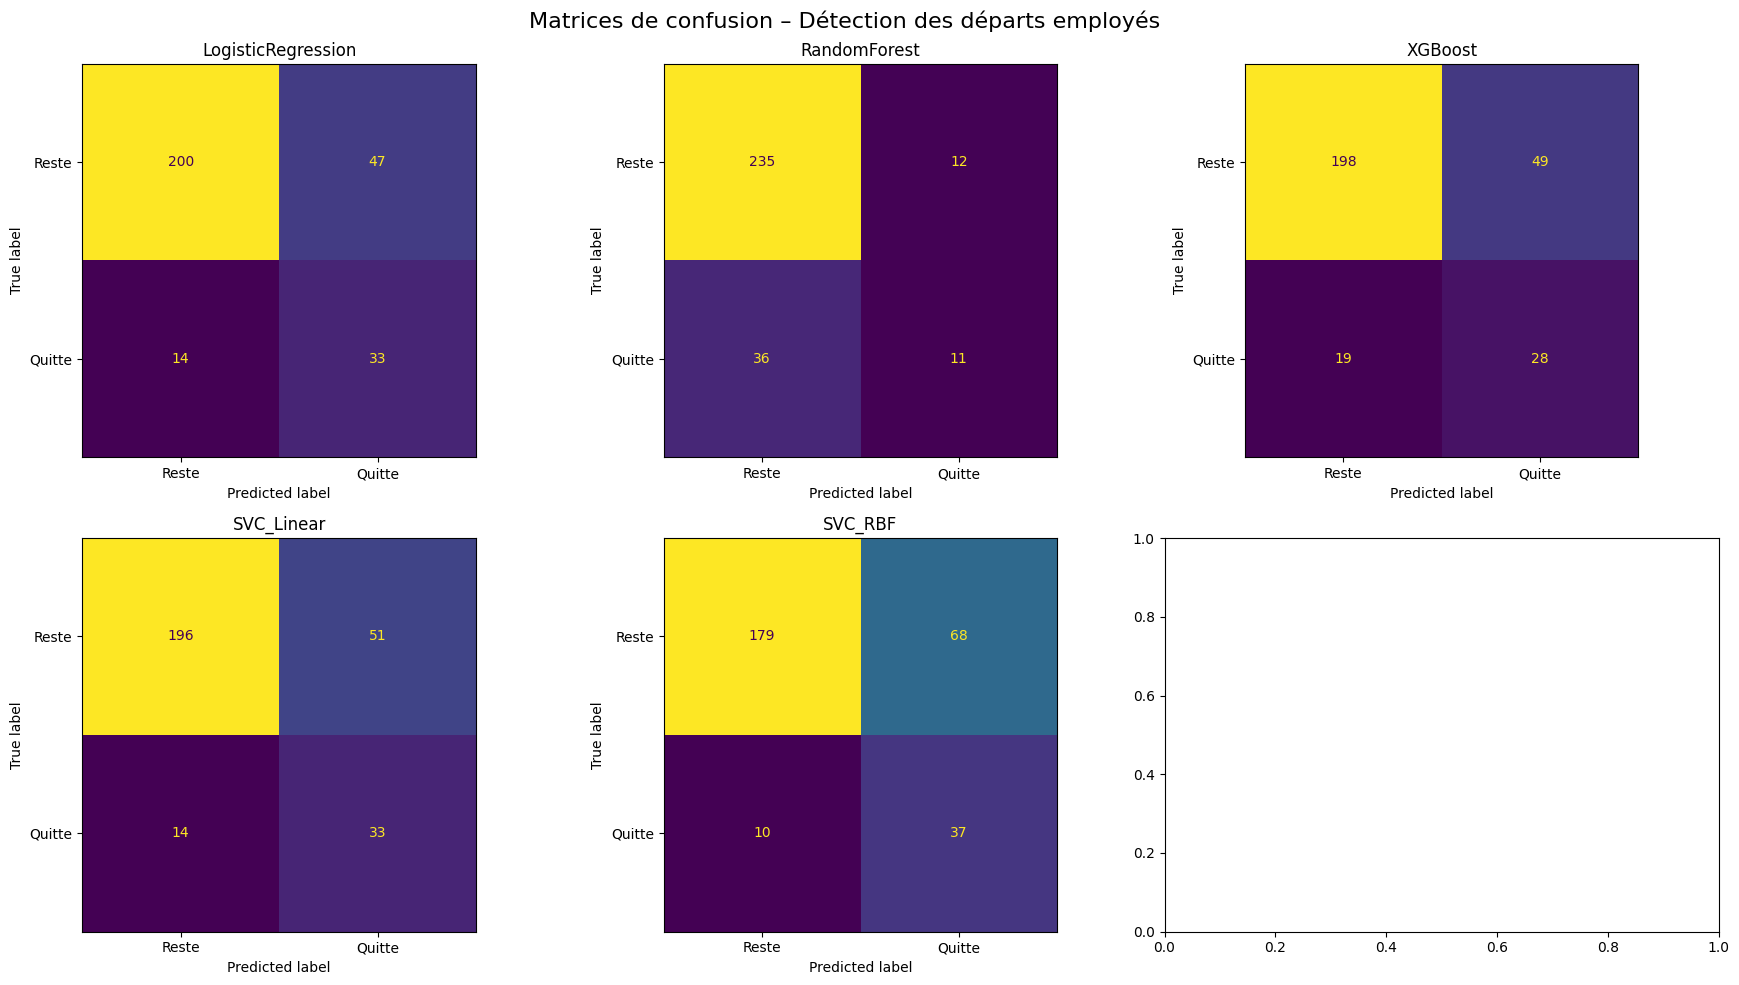

In [40]:
import matplotlib.pyplot as plt

# On importe les outils pour calculer et afficher une matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# On crée une figure contenant 2 lignes et 3 colonnes de graphiques, figsize définit la taille globale de la figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
# On transforme la grille (2x3) en une liste simple d'axes, cela facilite la boucle sur chaque graphique
axes = axes.flatten()

# On parcourt en même temps :
# - chaque zone de dessin (ax)
# - chaque modèle du dictionnaire "best_models_smote"
for ax, (name, model) in zip(axes, best_models_smote.items()):
    # Le modèle fait des prédictions sur les données de test
    y_pred = model.predict(X_test)

    # On calcule la matrice de confusion, elle compare les vraies valeurs aux valeurs prédites
    cm = confusion_matrix(y_test, y_pred)

    # On crée un objet pour afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(
        # Matrice de confusion calculée
        confusion_matrix=cm,
        # Noms lisibles des classes
        display_labels=["Reste", "Quitte"]
    )
    # On affiche la matrice dans le graphique courant. colorbar=False enlève la barre de couleurs pour plus de clarté
    disp.plot(ax=ax, colorbar=False)

    # On ajoute le nom du modèle comme titre du graphique
    ax.set_title(name)

# On ajoute un titre général à toute la figure
plt.suptitle("Matrices de confusion – Détection des départs employés", fontsize=16)
# Ajuste automatiquement les espacements pour éviter les chevauchements
plt.tight_layout()
# Affiche la figure finale
plt.show()


### Courbes ROC

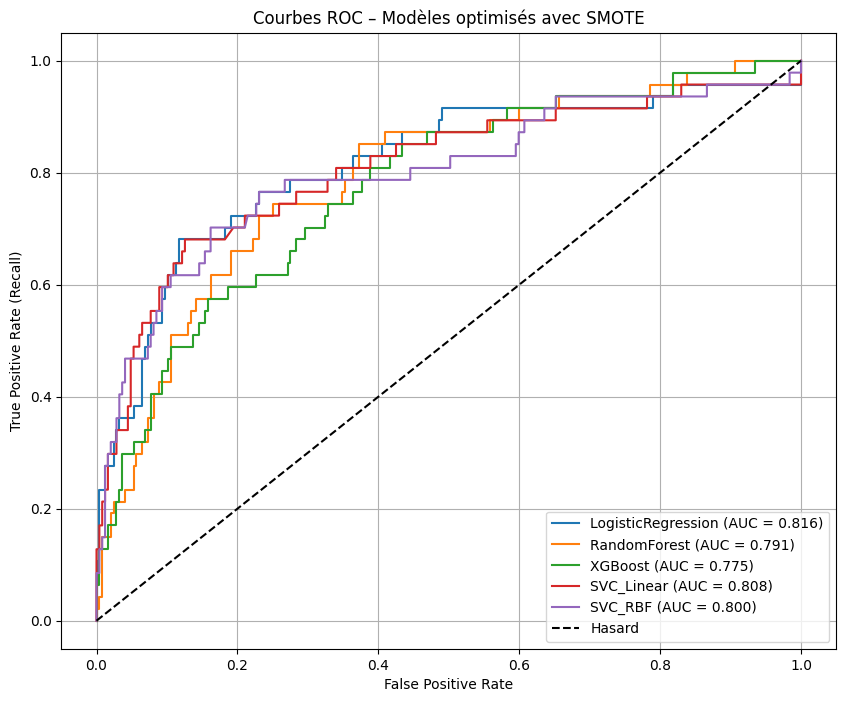

In [41]:
# On crée une nouvelle figure pour le graphique, figsize définit la taille de la figure
plt.figure(figsize=(10, 8))

# On parcourt chaque modèle du dictionnaire "best_models_smote"
# name = nom du modèle
# model = pipeline du modèle
for name, model in best_models_smote.items():
    # Le modèle prédit la probabilité d'appartenir à la classe "Quitte". [:, 1] correspond à la probabilité de la classe positive
    y_proba = model.predict_proba(X_test)[:, 1]
    # Calcul des points de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    # On calcule l'aire sous la courbe ROC (AUC)
    auc = roc_auc_score(y_test, y_proba)

    # On trace la courbe ROC du modèle, le label affiche le nom du modèle et sa valeur AUC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# On trace la diagonale correspondant à un modèle aléatoire, cette ligne sert de référence
plt.plot([0, 1], [0, 1], "k--", label="Hasard")

# On ajoute le nom des axes
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
# On ajoute un titre au graphique
plt.title("Courbes ROC – Modèles optimisés avec SMOTE")
# On affiche la légende
plt.legend()
# On ajoute une grille pour faciliter la lecture
plt.grid(True)
# On affiche le graphique final
plt.show()

---------------------------------------------------

# Courbe Precision/Recall et seuil optimal

La courbe Precision–Recall est un outil utilisé en classification binaire pour analyser le comportement d’un modèle lorsque l’on fait varier le seuil de décision. Contrairement à une prédiction binaire classique (0 ou 1), un modèle de classification produit généralement un score continu, souvent interprété comme une probabilité d’appartenir à la classe positive. Le seuil sert alors à transformer ce score en décision finale : si le score est supérieur ou égal au seuil, l’observation est classée comme positive, sinon elle est classée comme négative.

La précision mesure la proportion de prédictions positives qui sont réellement correctes. Elle répond à la question : « lorsque le modèle prédit la classe positive, a-t-il raison ? ». Le rappel, quant à lui, mesure la proportion de vrais positifs correctement détectés par le modèle. Il répond à la question : « parmi tous les cas réellement positifs, combien ont été identifiés par le modèle ? ». Ces deux métriques sont souvent en tension : améliorer le rappel conduit fréquemment à diminuer la précision, et inversement.

La courbe Precision–Recall permet de visualiser ce compromis. Chaque point de la courbe correspond à un seuil différent appliqué aux scores du modèle. Lorsque le seuil est élevé, le modèle est plus strict : il prédit peu de positifs, ce qui conduit généralement à une précision élevée mais à un rappel faible. À l’inverse, lorsque le seuil est bas, le modèle prédit davantage de positifs : le rappel augmente, mais la précision tend à diminuer. La courbe montre donc comment évoluent la précision et le rappel lorsque l’on modifie le seuil de décision.

Cette courbe est particulièrement pertinente dans le cas de jeux de données déséquilibrés, c’est-à-dire lorsque la classe positive est rare. Dans ce contexte, des métriques globales comme l’accuracy peuvent être trompeuses, tandis que la courbe Precision–Recall fournit une vision beaucoup plus informative de la performance réelle du modèle sur la classe d’intérêt.

La recherche d’un seuil optimal consiste à choisir le seuil de décision qui correspond le mieux à l’objectif du problème. Le seuil par défaut de 0,5 est arbitraire et n’est pas nécessairement le plus adapté. En pratique, modifier le seuil permet d’ajuster le comportement du modèle en fonction des priorités : limiter les faux positifs, réduire les faux négatifs ou trouver un compromis entre les deux.

Dans ce cadre, le F1-score est souvent utilisé pour déterminer un seuil optimal. Le F1-score est une métrique qui combine la précision et le rappel en une seule valeur, en cherchant un équilibre entre les deux. En calculant le F1-score pour chaque seuil possible, on peut identifier le seuil qui maximise cette métrique. Ce seuil correspond alors au meilleur compromis entre précision et rappel, en particulier lorsque les deux types d’erreurs ont une importance comparable.

Ainsi, la courbe Precision–Recall permet non seulement de visualiser les performances du modèle pour différents seuils, mais aussi de justifier de manière objective le choix d’un seuil optimal. L’utilisation de ce seuil optimisé conduit à des prédictions plus adaptées au problème réel que celles obtenues avec un seuil fixe par défaut.

In [42]:
import numpy as np
from sklearn.metrics import precision_recall_curve

Définition d'une fonction qui trace la courbe Precision-Recall et calcule le seuil optimal (F1 max) pour un pipeline sklearn.

In [43]:
def plot_pr_curve_and_find_threshold(model, X_test, y_test, model_name):
    # Définition de la fonction avec :
    # - model : le modèle entraîné
    # - X_test : les données de test
    # - y_test : les vraies étiquettes
    # - model_name : le nom du modèle (pour l’affichage)

    # Récupération des scores (probabilités ou decision function)

    # On vérifie si le modèle peut prédire des probabilités
    if hasattr(model, "predict_proba"):
        # On récupère la probabilité de la classe positive (classe 1)
        y_scores = model.predict_proba(X_test)[:, 1]
    # Sinon, on vérifie s’il fournit une fonction de décision    
    elif hasattr(model, "decision_function"):
        # On récupère les scores continus du modèle
        y_scores = model.decision_function(X_test)
    # Si aucune des deux méthodes n’existe
    else:
        # On lève une erreur car on ne peut pas tracer une PR curve
        raise ValueError(f"Le modèle {model_name} ne fournit pas de score continu.")

    # Calcul des valeurs de précision, rappel et des seuils associés (on enlève le dernier point car thresholds est plus court d’un élément)
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # Calcul du F1-score pour chaque seuil
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
    # On récupère l’indice du F1-score maximal
    best_idx = np.argmax(f1_scores)

    # Seuil correspondant au meilleur F1-score
    best_threshold = thresholds[best_idx]
    # Valeur maximale du F1-score
    best_f1 = f1_scores[best_idx]

    # Création de la figure matplotlib
    plt.figure(figsize=(7, 5))
    # Tracé de la courbe Precision-Recall
    plt.plot(recall, precision, label="PR curve")
    # Ajout d’un point rouge pour le seuil optimal
    plt.scatter(
        recall[best_idx],                                   # valeur de recall au meilleur seuil
        precision[best_idx],                                # valeur de precision au meilleur seuil
        color="red",                                        # couleur du point
        label=f"Seuil optimal = {best_threshold:.2f}"       # texte de la légende
    )
    # Nom de l’axe des abscisses
    plt.xlabel("Recall")
    # Nom de l’axe des ordonnées
    plt.ylabel("Precision")
    # Titre du graphique avec le nom du modèle
    plt.title(f"Precision-Recall – {model_name}")
    # Affichage de la légende
    plt.legend()
    # Ajout de la grille pour une meilleure lisibilité
    plt.grid(True)
    # Affichage du graphique
    plt.show()

    # La fonction retourne le meilleur seuil et le meilleur F1-score
    return best_threshold, best_f1


Modèle : LogisticRegression


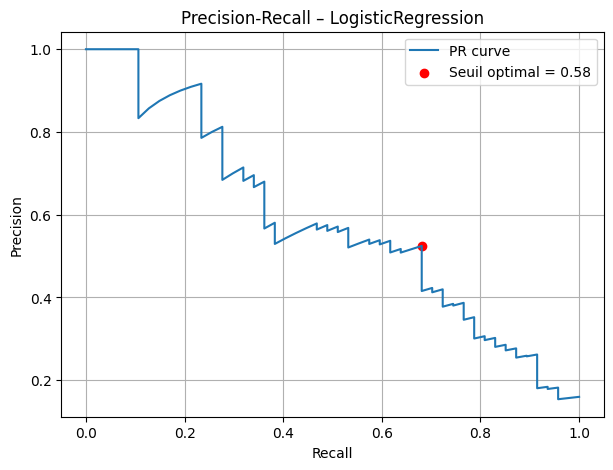

➡️ Seuil optimal : 0.579
➡️ F1-score max : 0.593
Modèle : RandomForest


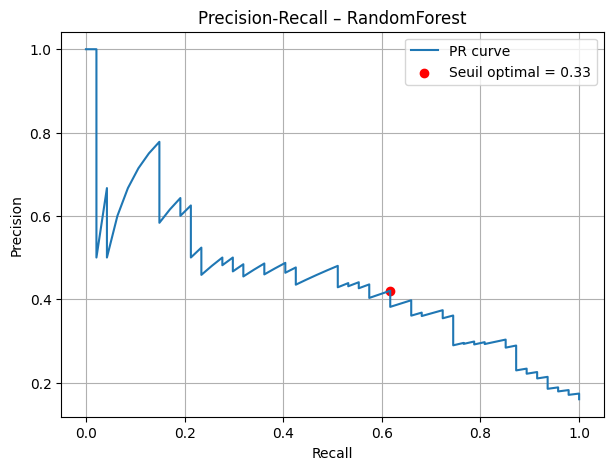

➡️ Seuil optimal : 0.334
➡️ F1-score max : 0.500
Modèle : XGBoost


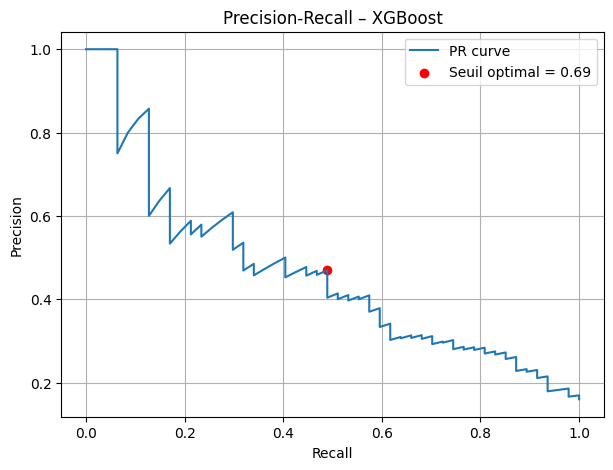

➡️ Seuil optimal : 0.694
➡️ F1-score max : 0.479
Modèle : SVC_Linear


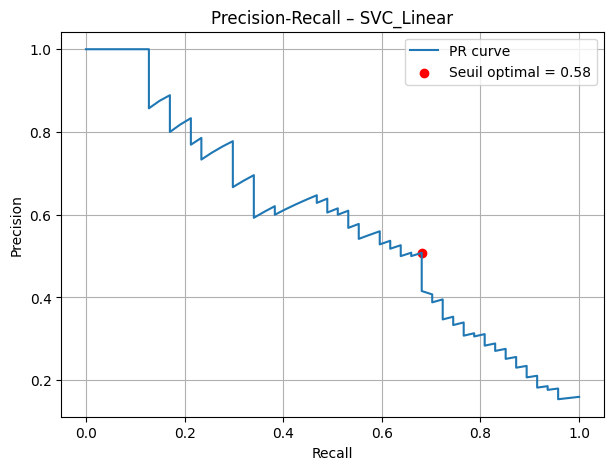

➡️ Seuil optimal : 0.583
➡️ F1-score max : 0.582
Modèle : SVC_RBF


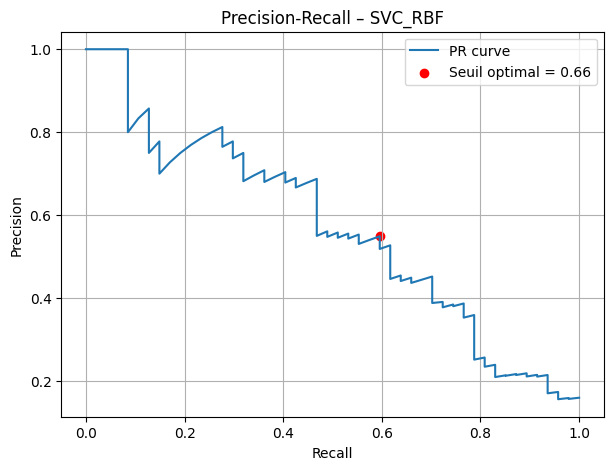

➡️ Seuil optimal : 0.665
➡️ F1-score max : 0.571


In [44]:
# Dictionnaire vide qui va stocker le seuil optimal pour chaque modèle
optimal_thresholds = {}

# Boucle sur chaque modèle du dictionnaire best_models_smote
# name : nom du modèle
# model : modèle entraîné correspondant
for name, model in best_models_smote.items():
    # Affiche une ligne de séparation pour plus de lisibilité dans la console
    print("=" * 60)
    # Affiche le nom du modèle en cours de traitement
    print(f"Modèle : {name}")


    # Appelle la fonction qui :
    # - trace la courbe Precision-Recall
    # - calcule le seuil optimal
    # - retourne le seuil optimal et le F1-score maximal
    threshold, f1 = plot_pr_curve_and_find_threshold(
        model,
        X_test,
        y_test,
        model_name=name
    )

    # Stocke le seuil optimal du modèle dans le dictionnaire. La clé est le nom du modèle, la valeur est le seuil
    optimal_thresholds[name] = threshold

    # Affiche le seuil optimal avec 3 chiffres après la virgule
    print(f"➡️ Seuil optimal : {threshold:.3f}")
    # Affiche le F1-score maximal associé à ce seuil
    print(f"➡️ F1-score max : {f1:.3f}")


In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Boucle sur chaque modèle entraîné avec SMOTE
# name : nom du modèle
# model : modèle correspondant
for name, model in best_models_smote.items():
    # Récupère le seuil optimal associé à ce modèle
    threshold = optimal_thresholds[name]

    # Si le modèle peut prédire des probabilités
    if hasattr(model, "predict_proba"):
        # On récupère la probabilité de la classe positive (classe 1)
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        # Sinon, on utilise la fonction de décision du modèle
        y_scores = model.decision_function(X_test)

    # Transformation des scores continus en prédictions binaires :
    # - 1 si le score est supérieur ou égal au seuil optimal
    # - 0 sinon
    y_pred_opt = (y_scores >= threshold).astype(int)

    # Affiche le nom du modèle (avec une ligne vide avant)
    print(f"\n{name}")
    # Calcule et affiche la précision avec le seuil optimal
    print("Precision :", precision_score(y_test, y_pred_opt))
    # Calcule et affiche le rappel avec le seuil optimal
    print("Recall    :", recall_score(y_test, y_pred_opt))
    # Calcule et affiche le F1-score avec le seuil optimal
    print("F1-score  :", f1_score(y_test, y_pred_opt))



LogisticRegression
Precision : 0.5245901639344263
Recall    : 0.6808510638297872
F1-score  : 0.5925925925925926

RandomForest
Precision : 0.42028985507246375
Recall    : 0.6170212765957447
F1-score  : 0.5

XGBoost
Precision : 0.46938775510204084
Recall    : 0.48936170212765956
F1-score  : 0.4791666666666667

SVC_Linear
Precision : 0.5079365079365079
Recall    : 0.6808510638297872
F1-score  : 0.5818181818181818

SVC_RBF
Precision : 0.5490196078431373
Recall    : 0.5957446808510638
F1-score  : 0.5714285714285714


### Interprétation

Un seuil de décision de 0.58 (Regression Logistique) signifie que le modèle classe une observation comme positive uniquement si sa probabilité prédite d’appartenir à la classe positive est au moins 58 %.  

Dans le cas de la Régression Logistique, le seuil de décision = 0.58 maximise le F1-score donc offre le meilleur équilibre entre :
- détecter les positifs (recall) = détecter les employés qui partent
- éviter les faux positifs (precision) = éviter les employés qui sont dit comme étant parti alors qu'ils sont restés

Les résultats montrent que l’optimisation du seuil a un impact significatif sur le comportement des modèles. De manière générale, cette optimisation conduit à une augmentation du rappel, parfois accompagnée d’une légère diminution de l’accuracy, ce qui traduit un modèle moins conservateur et davantage orienté vers la détection des instances positives. Cette évolution est attendue et cohérente avec l’objectif de maximisation du F1-score.

La régression logistique apparaît comme le modèle le plus performant après optimisation du seuil. Alors que ses performances avec le seuil par défaut étaient déjà équilibrées, l’ajustement du seuil permet d’augmenter significativement la précision tout en conservant un rappel élevé. Le F1-score obtenu est le plus élevé parmi l’ensemble des modèles testés, ce qui indique un excellent compromis entre la capacité du modèle à détecter les cas positifs et sa fiabilité lorsqu’il prédit cette classe. Ce résultat est cohérent avec la forme régulière et stable de sa courbe Precision–Recall.

Le SVC linéaire présente des performances très proches de celles de la régression logistique. L’optimisation du seuil améliore nettement la précision sans dégrader significativement le rappel, conduisant à un F1-score légèrement inférieur mais comparable. Ce comportement confirme la robustesse des modèles linéaires dans ce contexte et leur bonne capacité de généralisation sur des données déséquilibrées.

Le SVC à noyau RBF adopte un comportement différent. Initialement caractérisé par un rappel très élevé mais une précision plus faible, il bénéficie de l’optimisation du seuil par une amélioration marquée de la précision, au prix d’une diminution du rappel. Le F1-score progresse néanmoins de manière notable, traduisant un modèle plus équilibré. Ce modèle peut être pertinent dans des situations où la réduction des faux positifs est prioritaire, bien qu’il soit moins stable que les modèles linéaires.

Le Random Forest illustre bien les limites d’une évaluation basée uniquement sur l’accuracy. Avant optimisation, ce modèle présentait une accuracy élevée mais un rappel très faible, indiquant une forte tendance à prédire la classe majoritaire. L’ajustement du seuil permet de corriger ce biais en augmentant fortement le rappel, ce qui améliore sensiblement le F1-score. Malgré ce progrès, ses performances restent inférieures à celles des modèles linéaires, suggérant que sa complexité ne se traduit pas ici par un gain de performance sur la classe positive.

Enfin, XGBoost présente des performances relativement stables mais globalement modestes. L’optimisation du seuil n’entraîne qu’une amélioration limitée du F1-score, et le compromis entre précision et rappel reste moins favorable que pour les autres modèles. Cela peut indiquer un besoin d’ajustement plus fin des hyperparamètres ou une difficulté du modèle à capturer la structure du problème dans ce contexte précis.

En conclusion, cette analyse met en évidence l’importance du choix du seuil de décision dans les problèmes de classification déséquilibrée. L’optimisation du seuil à partir de la courbe Precision–Recall permet d’obtenir des modèles plus adaptés aux objectifs réels du problème. Parmi les modèles étudiés, la régression logistique et le SVC linéaire se distinguent comme les meilleurs compromis globaux, offrant des performances élevées, stables et interprétables. Ces résultats soulignent également que des modèles plus complexes ne garantissent pas nécessairement de meilleures performances, et que l’adéquation entre le modèle, le seuil et l’objectif métier demeure un élément central de l’évaluation.

--------------------------------------------

# Analyse des feature importances

In [46]:
import shap
import numpy as np
import pandas as pd

c:\Users\cpier\Desktop\PROJET\Classifiez_automatiquement_des_informations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
# Cette fonction permet de récupérer les noms des variables après le passage dans un ColumnTransformer
def get_feature_names_from_column_transformer(preprocessor):
    # Liste vide qui contiendra tous les noms de variables finales
    feature_names = []
    # On parcourt chaque transformation du ColumnTransformer
    # name        : nom du bloc de transformation
    # transformer : l'objet qui transforme les données
    # cols        : les colonnes concernées
    for name, transformer, cols in preprocessor.transformers_:
        # Si certaines colonnes ont été supprimées, on les ignore
        if transformer == "drop":
            continue
        # Si les colonnes sont laissées telles quelles
        if transformer == "passthrough":
            # On ajoute directement leurs noms
            feature_names.extend(cols)
        else:
            # Si le transformateur sait générer les nouveaux noms de variables (ex: OneHotEncoder, OrdinalEncoder, etc.)
            if hasattr(transformer, "get_feature_names_out"):
                # On récupère les nouveaux noms créés après transformation
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                # Sinon, on garde simplement les noms d'origine
                feature_names.extend(cols)
    # On retourne la liste complète des noms de variables transformées            
    return feature_names

# Cette fonction permet de récupérer les données X après application du prétraitement du pipeline
def get_X_transformed(pipeline, X):
    # On applique uniquement l'étape de prétraitement du pipeline
    X_t = pipeline.named_steps["preprocess"].transform(X)
    # Si le résultat est une matrice creuse (sparse matrix) on la convertit en tableau numpy classique
    if hasattr(X_t, "toarray"):
        X_t = X_t.toarray()
    # On retourne les données transformées
    return X_t

### Random Forest

In [48]:
# Récupération du pipeline Random Forest avec SMOTE

# On sélectionne le pipeline Random Forest depuis le dictionnaire "best_models_smote"
rf_pipeline = best_models_smote["RandomForest"]
# On récupère uniquement le modèle Random Forest (sans le prétraitement ni SMOTE)
rf_model = rf_pipeline.named_steps["model"]

# Transformation des données de test

# On applique uniquement le prétraitement du pipeline pour obtenir les données sous la forme utilisée par le modèle
X_test_transformed = get_X_transformed(rf_pipeline, X_test)

# Récupération des noms des variables

# On récupère les noms des variables après transformation (après encodage, normalisation, etc.)
feature_names = get_feature_names_from_column_transformer(
    # On utilise le preprocessor du pipeline
    rf_pipeline.named_steps["preprocess"]
)

# Vérification de cohérence

# On vérifie que le nombre de colonnes des données transformées correspond exactement au nombre de noms de variables. Si ce n'est pas le cas, une erreur est levée
assert X_test_transformed.shape[1] == len(feature_names)

In [49]:
# On transforme les données d'entraînement pour qu'elles aient exactement le même format que celui utilisé par le modèle Random Forest
X_background = get_X_transformed(
    # Pipeline Random Forest (prétraitement + SMOTE + modèle) et données d'entraînement originales
    rf_pipeline, X_train
)

# On sélectionne un sous-échantillon de 100 observations à partir des données transformées. Ces données serviront de "référence" pour SHAP
X_background = shap.sample(X_background, 100)

#### SHAP

Interprétation des valeurs SHAP :
- valeur SHAP positive : augmente la probabilité de départ
- valeur SHAP négative : diminue la probabilité de départ
- valeur proche de 0 : peu d’influence

Pourquoi utiliser predict_proba ? Parce que SHAP explique des variations de probabilité, ce qui est beaucoup plus informatif qu’une simple classe prédite.  

Dans le projet, l’objectif est d’expliquer les départs d’employés, pas les employés qui restent d'où le choix d'isoler la classe positive (1).

In [50]:
# On crée un objet "explainer" SHAP, il va servir à expliquer les prédictions du modèle Random Forest
explainer = shap.Explainer(
    # Fonction du modèle à expliquer, ici on explique les probabilités prédites par le modèle (predict_proba plutôt que predict)
    rf_model.predict_proba,
    # Données de référence (background) elles servent de point de comparaison pour les explications
    X_background
)

# On calcule les valeurs SHAP pour les données de test transformées. SHAP mesure l'impact de chaque variable sur chaque prédiction
shap_values = explainer(X_test_transformed)
# On extrait uniquement les valeurs SHAP associées à la classe positive. Ici, la classe 1 correspond à "Quitte"
shap_values_pos = shap_values.values[:, :, 1]

PermutationExplainer explainer: 295it [02:55,  1.64it/s]                         


C:\Users\cpier\AppData\Local\Temp\ipykernel_13928\1862124225.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


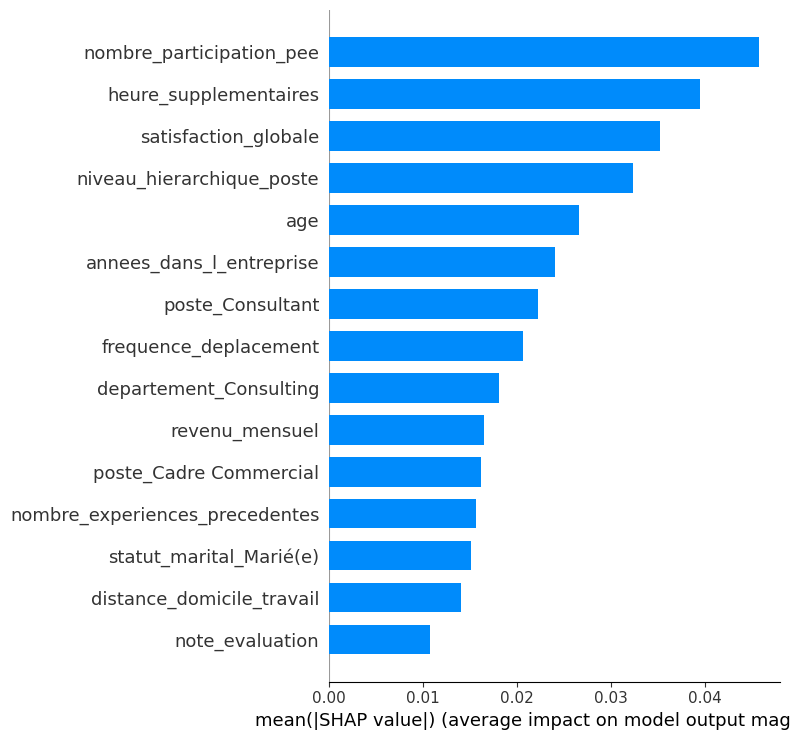

In [51]:
# On crée un graphique SHAP de type "bar". Ce graphique montre l'importance globale des variables
shap.summary_plot(
    # Valeurs SHAP associées à la classe positive ("Quitte")
    shap_values_pos,
    # Données de test transformées, elles servent de base pour calculer l'importance moyenne
    X_test_transformed,
    # Noms des variables après prétraitement
    feature_names=feature_names,
    # Type de graphique : barres. Chaque barre représente l'importance moyenne d'une variable
    plot_type="bar",
    # Nombre maximum de variables affichées. Ici, on affiche les 15 variables les plus importantes
    max_display=15
)

Ce graphique SHAP met en évidence les variables ayant le plus fort impact sur la prédiction du départ des employés. Les facteurs liés à l’engagement, à la charge de travail et à la trajectoire professionnelle apparaissent comme les principaux déterminants du risque de départ, devant les variables purement financières.

C:\Users\cpier\AppData\Local\Temp\ipykernel_13928\2576985294.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


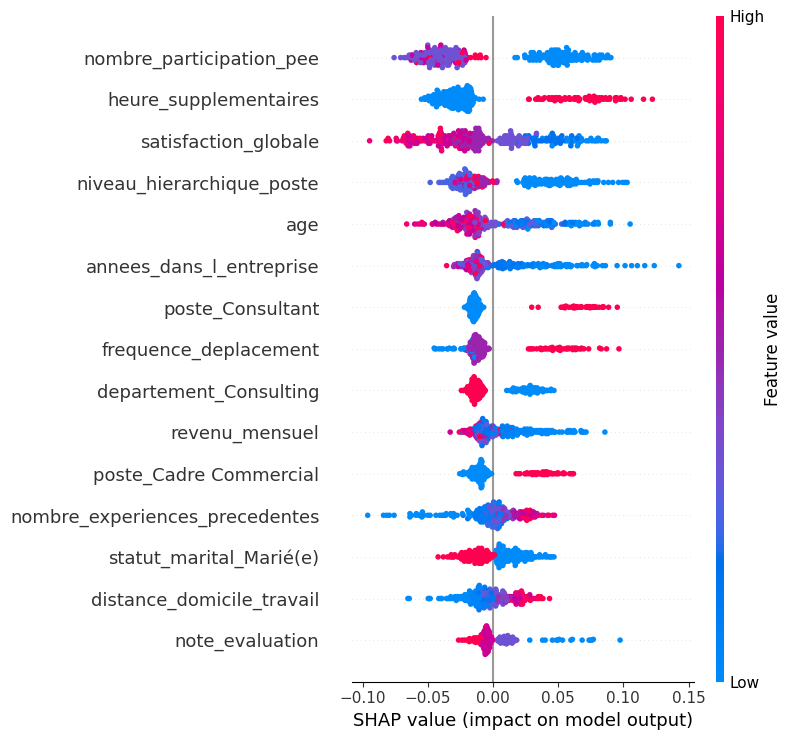

In [52]:
# On crée un graphique SHAP de type "summary" (beeswarm). Ce graphique montre à la fois :
# - l'importance des variables
# - le sens de leur influence (positive ou négative)
shap.summary_plot(
    # Valeurs SHAP associées à la classe positive ("Quitte")
    shap_values_pos,
    # Données de test transformées, chaque point représente un employé
    X_test_transformed,
    # Noms des variables après prétraitement
    feature_names=feature_names,
    # Nombre maximum de variables affichées. Ici, on affiche les 15 variables les plus importantes
    max_display=15
)

**Interprétation du graphique SHAP**

Ce graphique SHAP permet d’interpréter globalement le fonctionnement du modèle Random Forest utilisé pour prédire les départs d’employés. Il montre à la fois quelles variables influencent le plus les prédictions et dans quel sens elles agissent (augmentation ou diminution du risque de départ).

Les variables sont classées de haut en bas par importance décroissante, c’est-à-dire selon leur contribution moyenne aux prédictions du modèle. Chaque point représente un employé. La position horizontale du point indique l’impact de la variable sur la probabilité de départ :
- une valeur SHAP positive augmente la probabilité de départ
- une valeur SHAP négative la diminue

La couleur du point correspond à la valeur de la variable :
- rouge = valeur élevée
- bleu = valeur faible

* Variables les plus influentes

La variable nombre_participation_pee est la plus importante. On observe que des valeurs élevées (points rouges) sont majoritairement associées à des valeurs SHAP négatives, ce qui signifie qu’une forte participation au plan d’épargne entreprise réduit la probabilité de départ. À l’inverse, une faible participation est associée à un risque de départ plus élevé. Cela suggère que l’engagement financier et l’ancrage dans l’entreprise jouent un rôle protecteur.

Les heures supplémentaires constituent un facteur de risque majeur. Des valeurs élevées sont clairement associées à des valeurs SHAP positives, indiquant que les employés effectuant beaucoup d’heures supplémentaires ont une probabilité accrue de quitter l’entreprise. Cette variable traduit probablement une surcharge de travail ou un déséquilibre entre vie professionnelle et personnelle.

La satisfaction globale a un effet très marqué. Les faibles niveaux de satisfaction (points bleus) augmentent fortement le risque de départ, tandis que des niveaux élevés réduisent significativement cette probabilité. Cette variable apparaît comme l’un des leviers les plus importants pour la rétention des employés.

Le niveau hiérarchique du poste influence également le risque de départ. Les niveaux hiérarchiques plus élevés sont globalement associés à une probabilité de départ plus faible, ce qui peut s’expliquer par de meilleures conditions de travail, plus de responsabilités valorisantes ou une plus grande stabilité.

* Variables liées au parcours professionnel

L’âge et le nombre d’années dans l’entreprise ont des effets similaires. Les employés plus jeunes et avec peu d’ancienneté présentent un risque de départ plus élevé, tandis que l’âge et l’ancienneté agissent comme des facteurs de stabilité. Cela reflète un attachement progressif à l’entreprise au fil du temps.

Le nombre d’expériences professionnelles précédentes est associé à une augmentation du risque de départ lorsque ce nombre est élevé. Les profils ayant un parcours professionnel plus mobile semblent plus enclins à changer d’employeur.

* Variables liées au poste et à la mobilité

Le fait d’occuper un poste de Consultant ou de Cadre Commercial augmente la probabilité de départ. Ces fonctions sont souvent associées à une pression élevée, des objectifs commerciaux contraignants ou des opportunités externes nombreuses.

La fréquence des déplacements professionnels est également un facteur de risque. Des déplacements fréquents augmentent la probabilité de départ, ce qui peut refléter une fatigue liée à la mobilité ou une contrainte personnelle.

Le fait d’appartenir au département Consulting semble réduire légèrement le risque de départ, possiblement en raison d’une meilleure cohésion d’équipe ou d’opportunités d’évolution spécifiques.

* Variables personnelles et conditions de travail

Le revenu mensuel joue un rôle protecteur : des salaires plus élevés sont associés à une probabilité de départ plus faible. À l’inverse, un revenu faible augmente le risque de départ.

La distance domicile–travail a un impact modéré mais cohérent : une distance élevée augmente la probabilité de départ, ce qui est logique au regard de la fatigue et du temps de transport.

Le statut marital (marié) est globalement associé à une probabilité de départ plus faible, suggérant une plus grande recherche de stabilité professionnelle.

Enfin, une note d’évaluation élevée réduit le risque de départ, tandis que de mauvaises évaluations sont associées à une probabilité plus forte de quitter l’entreprise.

**Conclusion**

Ce graphique SHAP montre que les départs d’employés sont principalement influencés par des facteurs liés à l’engagement, la satisfaction, la charge de travail et les conditions de travail. Les variables les plus critiques sont la satisfaction globale, les heures supplémentaires, l’ancienneté, l’âge et l’implication dans les dispositifs internes de l’entreprise.

L’intérêt majeur de cette analyse est qu’elle permet de transformer un modèle prédictif complexe en leviers d’action concrets pour les ressources humaines, tels que l’amélioration des conditions de travail, la gestion de la charge horaire, la reconnaissance salariale et le renforcement de l’engagement des employés.

### XGBoost

In [53]:
xgb_pipeline = best_models_smote["XGBoost"]
xgb_model = xgb_pipeline.named_steps["model"]

X_test_transformed = get_X_transformed(xgb_pipeline, X_test)

feature_names = get_feature_names_from_column_transformer(
    xgb_pipeline.named_steps["preprocess"]
)

assert X_test_transformed.shape[1] == len(feature_names)


In [54]:
X_background = get_X_transformed(xgb_pipeline, X_train)
X_background = shap.sample(X_background, 100)

In [55]:
explainer_xgb = shap.Explainer(
    xgb_model.predict_proba,
    X_background
)

shap_values_xgb = explainer_xgb(X_test_transformed)
shap_values_xgb_pos = shap_values_xgb.values[:, :, 1]


C:\Users\cpier\AppData\Local\Temp\ipykernel_13928\2884127347.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


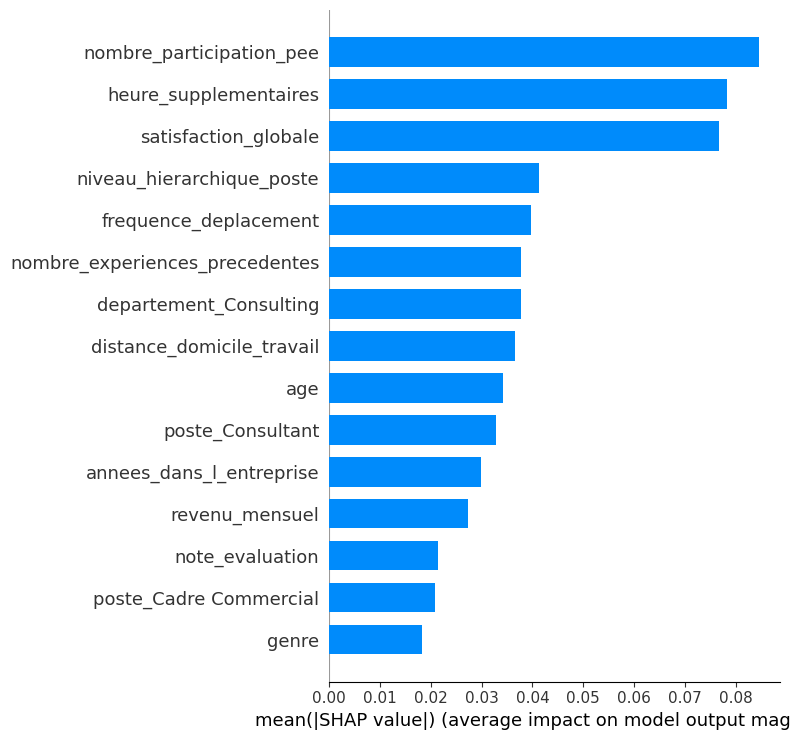

In [56]:
shap.summary_plot(
    shap_values_xgb_pos,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)


C:\Users\cpier\AppData\Local\Temp\ipykernel_13928\4109788232.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


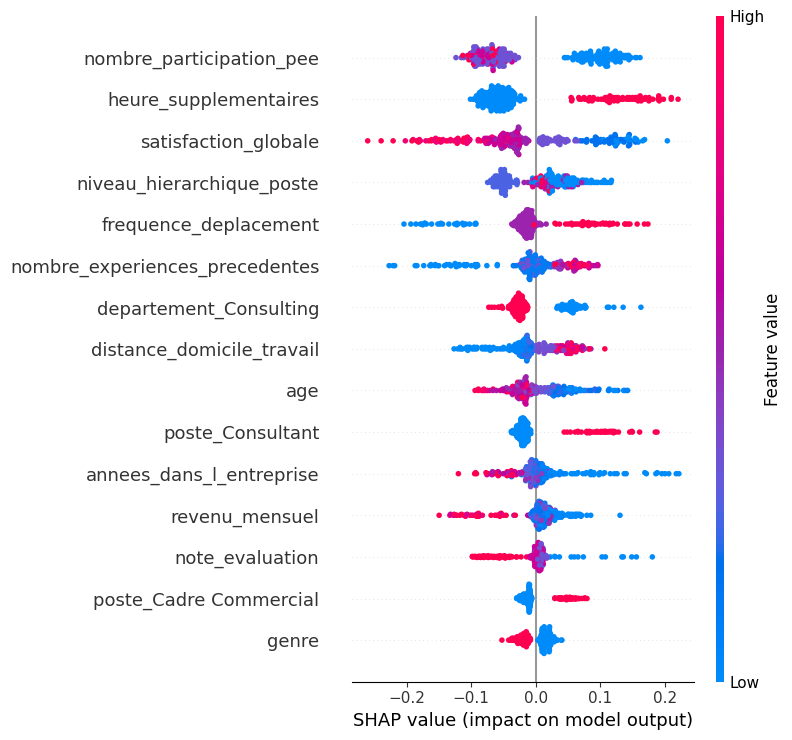

In [57]:
shap.summary_plot(
    shap_values_xgb_pos,
    X_test_transformed,
    feature_names=feature_names,
    max_display=15
)


### Régression Logistique

In [58]:
logreg_pipeline = best_models_smote["LogisticRegression"]
logreg_model = logreg_pipeline.named_steps["model"]

X_test_transformed = get_X_transformed(logreg_pipeline, X_test)

feature_names = get_feature_names_from_column_transformer(
    logreg_pipeline.named_steps["preprocess"]
)

assert X_test_transformed.shape[1] == len(feature_names)


In [59]:
X_background = get_X_transformed(logreg_pipeline, X_train)
X_background = shap.sample(X_background, 100)


In [60]:
explainer_lr = shap.Explainer(
    logreg_model.predict_proba,
    X_background
)

shap_values_lr = explainer_lr(X_test_transformed)
shap_values_lr_pos = shap_values_lr.values[:, :, 1]


C:\Users\cpier\AppData\Local\Temp\ipykernel_13928\2315220510.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


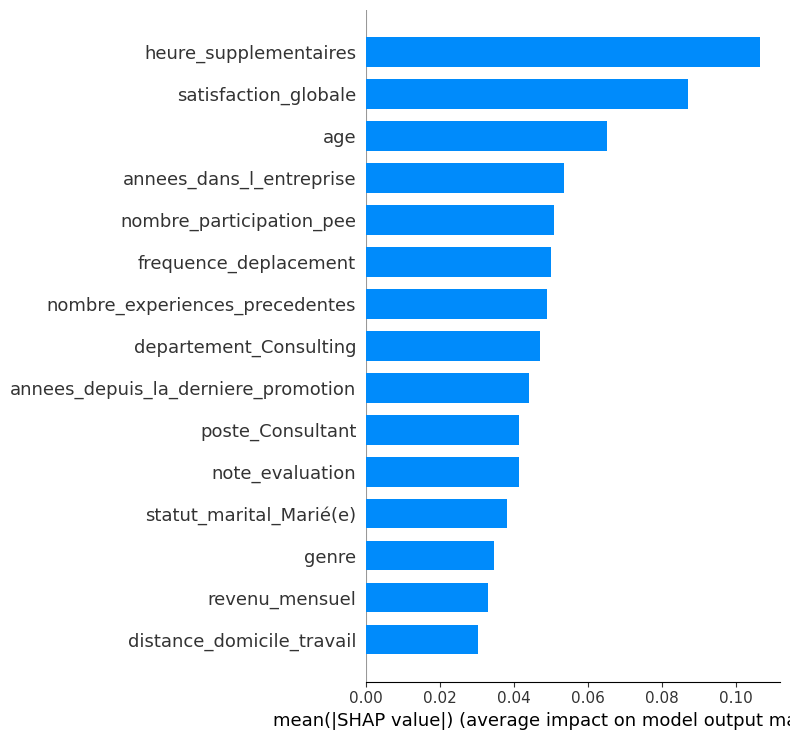

In [61]:
shap.summary_plot(
    shap_values_lr_pos,
    X_test_transformed,
    feature_names=feature_names,
    plot_type="bar",
    max_display=15
)


C:\Users\cpier\AppData\Local\Temp\ipykernel_13928\1456451808.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


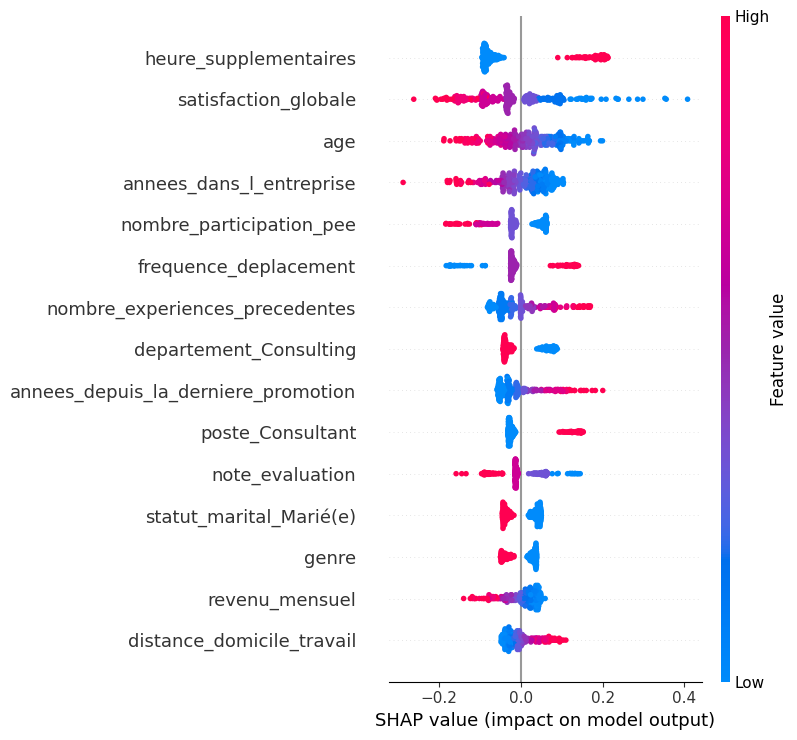

In [62]:
shap.summary_plot(
    shap_values_lr_pos,
    X_test_transformed,
    feature_names=feature_names,
    max_display=15
)


**Interprétation du graphique SHAP**

Ce graphique SHAP illustre le fonctionnement du modèle de régression logistique utilisé pour prédire les départs d’employés. Contrairement au Random Forest, la régression logistique est un modèle linéaire, ce qui signifie que l’impact de chaque variable sur la probabilité de départ est plus direct, plus régulier et plus interprétable.

Les variables sont classées de haut en bas selon leur importance décroissante, c’est-à-dire leur contribution moyenne aux prédictions du modèle. Chaque point représente un employé. L’axe horizontal correspond à l’impact de la variable sur la probabilité de départ :
- une valeur SHAP positive augmente la probabilité de départ
- une valeur SHAP négative la diminue

La couleur des points indique la valeur de la variable :
- rouge = valeur élevée,
- bleu = valeur faible.

* Facteurs principaux de départ

La variable la plus influente est le nombre d’heures supplémentaires. On observe clairement que des valeurs élevées sont associées à des valeurs SHAP positives, ce qui signifie qu’un volume important d’heures supplémentaires augmente fortement la probabilité de départ. À l’inverse, un faible nombre d’heures supplémentaires agit comme un facteur de stabilité. Ce résultat met en évidence l’impact de la charge de travail sur le turnover.

La satisfaction globale apparaît comme un facteur protecteur majeur. Les niveaux élevés de satisfaction sont associés à une diminution de la probabilité de départ, tandis que les niveaux faibles augmentent fortement le risque. Cet effet est très net et cohérent sur l’ensemble des observations, ce qui confirme l’importance centrale de la satisfaction des employés.

L’âge et le nombre d’années passées dans l’entreprise montrent un effet stabilisateur. Les employés plus jeunes et avec peu d’ancienneté présentent une probabilité de départ plus élevée, tandis que l’âge et l’ancienneté réduisent progressivement ce risque. Ces résultats traduisent un attachement croissant à l’entreprise au fil du temps.

La participation au plan d’épargne entreprise (PEE) est également un facteur de rétention. Une forte participation est associée à une diminution du risque de départ, tandis qu’une faible participation augmente la probabilité de quitter l’entreprise. Ce facteur reflète l’engagement financier et la projection à long terme des employés.

* Facteurs liés à la mobilité et au parcours professionnel

La fréquence des déplacements professionnels a un impact positif sur la probabilité de départ lorsque cette fréquence est élevée. Les déplacements fréquents semblent augmenter la fatigue et réduire l’équilibre vie professionnelle–vie personnelle.

Le nombre d’expériences professionnelles précédentes est associé à une augmentation du risque de départ. Les profils ayant un parcours plus mobile apparaissent naturellement plus enclins à changer d’entreprise.

Le fait d’occuper un poste de Consultant augmente la probabilité de départ, ce qui est cohérent avec la forte pression, la mobilité et les opportunités externes généralement associées à ce type de fonction.

* Variables organisationnelles et personnelles

L’appartenance au département Consulting tend à réduire légèrement le risque de départ, suggérant un effet de structure ou de cohésion propre à ce département.

Le temps écoulé depuis la dernière promotion joue un rôle important : plus ce délai est long, plus la probabilité de départ augmente. Ce résultat souligne l’importance des perspectives d’évolution professionnelle.

La note d’évaluation agit comme un facteur protecteur : de bonnes évaluations sont associées à une diminution du risque de départ, tandis que des évaluations faibles augmentent la probabilité de quitter l’entreprise.

Le statut marital (marié) est globalement associé à une plus grande stabilité professionnelle, avec une probabilité de départ plus faible.

Le revenu mensuel a un effet modéré mais cohérent : des salaires plus élevés réduisent le risque de départ.

La distance domicile–travail augmente légèrement la probabilité de départ lorsque celle-ci est élevée, reflétant une contrainte logistique supplémentaire.

Enfin, la variable genre a un impact faible comparé aux autres facteurs, suggérant qu’elle joue un rôle secondaire dans la décision de départ.

* Comparaison avec le modèle Random Forest

Par rapport au Random Forest, la régression logistique présente des effets plus linéaires et plus lisibles. Les relations entre variables et probabilité de départ sont moins complexes mais plus faciles à interpréter. Cela explique pourquoi ce modèle offre un bon compromis entre performance et interprétabilité, particulièrement adapté à un contexte RH.

**Conclusion**

L’analyse SHAP du modèle de régression logistique met en évidence que les départs d’employés sont principalement expliqués par la charge de travail, la satisfaction, l’ancienneté, les opportunités d’évolution et la mobilité professionnelle. Ces résultats sont cohérents, stables et directement exploitables pour la prise de décision.

Ce modèle permet ainsi non seulement de prédire les départs, mais aussi de fournir des leviers d’action clairs et opérationnels pour améliorer la rétention des employés.

### Tableau d’importances SHAP

In [63]:
shap_importances_lr = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": np.abs(shap_values_lr_pos).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)

shap_importances_lr.head(15)


,feature,mean_abs_shap
4,heure_supplementaires,0.106617
9,satisfaction_globale,0.086946
0,age,0.065151
2,annees_dans_l_entreprise,0.053584
10,nombre_participation_pee,0.050924
15,frequence_deplacement,0.049924
7,nombre_experiences_precedentes,0.048949
23,departement_Consulting,0.047033
3,annees_depuis_la_derniere_promotion,0.044102
26,poste_Consultant,0.041369


Ce tableau présente les variables les plus influentes du modèle de régression logistique, classées par importance décroissante, mesurée à l’aide de la moyenne des valeurs SHAP absolues.
Cette métrique indique l’intensité moyenne de l’impact de chaque variable sur les prédictions du modèle, sans tenir compte du sens (augmentation ou diminution du risque).

Ainsi, plus la valeur moyenne SHAP est élevée, plus la variable joue un rôle important dans la décision du modèle.  

Ce tableau d’importances confirme que les départs d’employés sont principalement expliqués par des facteurs liés à la charge de travail, à la satisfaction, à la stabilité professionnelle et aux perspectives d’évolution. Les variables personnelles et financières jouent un rôle complémentaire mais moins déterminant.

L’intérêt de cette analyse réside dans sa capacité à transformer les prédictions du modèle en leviers d’action concrets pour les ressources humaines, tels que la gestion des heures supplémentaires, l’amélioration de la satisfaction au travail, la reconnaissance de l’ancienneté et la mise en place de parcours d’évolution clairs.

-------------------------------------------------------

# **Conclusion finale**

### Choix du meilleur modèle pour la détection des départs employés

L’objectif principal de ce projet était de construire un modèle capable de détecter efficacement les départs d’employés, dans un contexte où la classe “Quitte” est minoritaire et où rater un départ réel représente un coût métier élevé. Pour cette raison, l’évaluation des modèles ne s’est pas limitée à l’accuracy, mais s’est appuyée sur des métriques plus adaptées telles que le recall, les matrices de confusion, les courbes ROC/AUC, ainsi que des méthodes d’interprétabilité.

**Analyse comparative des performances**

L’analyse des métriques globales montre que le Random Forest obtient la meilleure accuracy, mais cette performance est trompeuse. Sa matrice de confusion révèle un recall très faible pour la classe “Quitte”, ce qui signifie qu’il manque la majorité des départs réels. Malgré l’utilisation de SMOTE et l’optimisation par GridSearchCV, ce modèle reste fortement biaisé vers la classe majoritaire et s’avère inadapté à l’objectif métier.

Le XGBoost affiche des performances intermédiaires. Son recall et son AUC sont corrects, mais inférieurs à ceux des meilleurs modèles. Sa complexité supplémentaire n’apporte pas de gain significatif par rapport à des modèles plus simples, ce qui limite son intérêt dans ce contexte.

Les SVM, en particulier le SVM linéaire et le SVM RBF, montrent de très bons résultats. Ils obtiennent des recalls élevés, proches ou supérieurs à ceux de la régression logistique, et des AUC solides. Le SVM RBF atteint même le meilleur recall sur le jeu de test. Cependant, cette performance s’accompagne d’un nombre plus important de faux positifs, comme le montrent les matrices de confusion, ce qui peut générer davantage de fausses alertes en pratique.

La régression logistique optimisée avec SMOTE se distingue par un excellent équilibre global. Elle présente :
- un recall élevé, garantissant une bonne détection des départs
- une AUC parmi les plus élevées, indiquant une bonne capacité de discrimination
- une stabilité confirmée par la validation croisée
- une matrice de confusion équilibrée, avec un compromis maîtrisé entre faux négatifs et faux positifs

**Apport de l’interprétabilité**

Un élément clé dans le choix final du modèle réside dans son interprétabilité. Les analyses SHAP montrent que la régression logistique identifie de manière claire et cohérente les facteurs expliquant les départs : heures supplémentaires, satisfaction globale, ancienneté, âge, perspectives de promotion, mobilité et rémunération. Ces résultats sont facilement compréhensibles par des acteurs RH et directement exploitables pour la prise de décision.

À l’inverse, bien que les modèles plus complexes offrent parfois des performances comparables, leur interprétation est plus délicate et moins transparente.

**Conclusion finale**

Au regard de l’ensemble des éléments analysés (métriques de performance, matrices de confusion, courbes ROC, optimisation par GridSearchCV et interprétabilité) la régression logistique optimisée avec SMOTE apparaît comme le meilleur modèle pour la détection des départs d’employés.

Elle offre le meilleur compromis entre efficacité prédictive, robustesse, simplicité et explicabilité, ce qui en fait un choix particulièrement adapté à un contexte de ressources humaines, où la compréhension des facteurs de départ est aussi importante que la performance du modèle lui-même.

Ce modèle permet ainsi non seulement d’anticiper les départs, mais également de fournir des leviers d’action concrets pour améliorer la rétention des employés, ce qui répond pleinement aux objectifs du projet.

### Recommandations pour réduire le turnover

À partir des résultats du modèle et de l’analyse des facteurs explicatifs, plusieurs leviers d’action concrets peuvent être identifiés afin de réduire durablement le turnover des employés.

**1. Mieux maîtriser la charge de travail et les heures supplémentaires**

La charge de travail, mesurée par le nombre d’heures supplémentaires, apparaît comme le facteur le plus fortement associé aux départs. L’entreprise a tout intérêt à :
- mettre en place un suivi régulier des heures supplémentaires
- identifier les équipes ou les postes structurellement en surcharge
- ajuster la répartition des tâches ou renforcer les effectifs lorsque cela est nécessaire

Une meilleure gestion de la charge de travail permettrait de limiter la fatigue, le stress et l’épuisement professionnel, qui sont des déclencheurs majeurs de départ.

**2. Renforcer la satisfaction globale des employés**

La satisfaction globale est un levier central de rétention. Pour agir efficacement, l’entreprise pourrait :
- réaliser des enquêtes de satisfaction régulières et anonymes
- analyser les résultats par service, ancienneté ou type de poste
- mettre en place des plans d’action ciblés (amélioration du management de proximité, reconnaissance, conditions de travail)

Une attention particulière doit être portée aux employés exprimant une baisse de satisfaction, car ils constituent un groupe à risque élevé de départ.

**3. Donner de la visibilité sur les perspectives d’évolution**

Le temps écoulé depuis la dernière promotion est un facteur important de départ. L’entreprise gagnerait à :
- clarifier les parcours de carrière possibles
- définir des critères transparents d’évolution
- organiser des entretiens réguliers sur les perspectives professionnelles

Donner de la visibilité sur l’évolution permet de renforcer l’engagement et de limiter le sentiment de stagnation.

**4. Fidéliser les profils jeunes et peu anciens**

Les employés jeunes et avec peu d’ancienneté sont plus susceptibles de quitter l’entreprise. Des actions spécifiques peuvent être mises en place :
- programmes de mentorat pour les nouveaux arrivants
- accompagnement renforcé durant les premières années
- intégration progressive dans des projets valorisants

L’objectif est de créer rapidement un sentiment d’appartenance et d’attachement à l’entreprise.

**5. Réduire les contraintes liées à la mobilité et aux déplacements**

La fréquence des déplacements et la distance domicile–travail ont un impact négatif sur la rétention. L’entreprise pourrait :
- favoriser le télétravail lorsque cela est possible
- optimiser l’organisation des déplacements
- proposer des compensations ou aménagements pour les situations les plus contraignantes

Ces mesures contribuent à améliorer l’équilibre vie professionnelle–vie personnelle.

**6. Valoriser l’engagement et la performance**

Les employés bien évalués, engagés dans des dispositifs internes (comme le plan d’épargne entreprise) ou bénéficiant d’une rémunération plus attractive présentent un risque de départ plus faible. Il est donc recommandé de :
- renforcer les dispositifs de reconnaissance et de valorisation
- encourager l’adhésion aux mécanismes d’engagement à long terme
- veiller à l’équité salariale

### Ouverture : pistes d’amélioration et prolongements de la modélisation

Le travail de modélisation réalisé est assez complet : plusieurs familles de modèles ont été comparées, le déséquilibre des classes a été traité par pondération et par SMOTE, les hyperparamètres ont été optimisés via GridSearchCV, et l’interprétabilité a été approfondie à l’aide de SHAP.
Néanmoins, certaines pistes complémentaires auraient pu être explorées pour enrichir encore l’approche.

1. **Optimisation explicite du seuil de décision**

Dans la modélisation, les modèles utilisent le seuil par défaut de 0,5 pour convertir les probabilités en classes, et la comparaison repose ensuite sur les métriques classiques (recall, AUC, matrices de confusion).

Une amélioration possible aurait été de :
- déterminer un seuil optimal spécifique à l’objectif métier
- par exemple en maximisant le recall sous contrainte d’un taux acceptable de faux positifs
- ou en s’appuyant sur la courbe Precision–Recall

Cela aurait permis d’adapter encore plus finement les prédictions aux contraintes opérationnelles de l’entreprise.

2. **Analyse de stabilité des modèles**

Les performances ont été évaluées de manière robuste via validation croisée, mais une analyse complémentaire aurait pu consister à :
- mesurer la variabilité des performances sur plusieurs découpages train/test
- comparer la stabilité des coefficients (régression logistique) ou des importances SHAP
- identifier les modèles les plus robustes face aux variations de l’échantillon  

Cette analyse aurait renforcé la confiance dans le choix final du modèle.

3. **Feature engineering avancé**

Le preprocessing est solide et bien structuré, mais peu de feature engineering métier a été ajouté au-delà des variables existantes.

Des améliorations possibles auraient été :
- création de variables composites (ex : heures supplémentaires rapportées à l’ancienneté)
- regroupement ou hiérarchisation de certaines catégories rares

Cela aurait pu permettre aux modèles de capter des signaux plus fins.

4. **Modèles orientés temps avant départ (survival analysis)**

Le problème a été formulé comme une classification binaire (reste / quitte). Une extension naturelle du travail aurait été de reformuler le problème comme :
- une prédiction du temps avant départ
- à l’aide de modèles de survie (Cox, survival forests)

Cette approche aurait permis d’anticiper quand un employé est susceptible de partir, et non seulement s’il va partir, ce qui est particulièrement pertinent pour la planification RH.

5. **Segmentation des modèles par population**

Enfin,, le modèle global fonctionne bien, mais une piste intéressante aurait été de :
- entraîner des modèles spécifiques par type de population (jeunes employés, consultants, cadres, etc)
- analyser si certains facteurs explicatifs varient selon les profils

Cette segmentation aurait permis une approche plus personnalisée du risque de départ.

Conclusion de l’ouverture :

Ces pistes montrent que la modélisation réalisée est déjà aboutie et cohérente avec l’objectif du projet. Les prolongements proposés ne remettent pas en cause les choix effectués, mais ouvrent des perspectives d’amélioration autour de l’optimisation opérationnelle, de la robustesse, et de la temporalité du phénomène étudié.

Elles constituent des axes naturels pour un approfondissement futur du travail.

--------------------------------------------------------------------------------------------------

# Export du pipeline

In [65]:
import joblib
from pathlib import Path

Path("models").mkdir(exist_ok=True)

joblib.dump(best_models_smote["LogisticRegression"], "models/logreg_pipeline.joblib")

print("Modèle exporté dans models/logreg_pipeline.joblib")

Modèle exporté dans models/logreg_pipeline.joblib
